# MLOps Pipeline for Automated Weather Forecasting

## Project Overview

### Problem Statement
The central challenge this project addresses is **‘model drift’**, a critical issue where the performance of machine learning models in production degrades over time as real-world data patterns evolve. Unlike standard academic projects which often result in static models, this project focuses on real-world applicability by creating a system that adapts.

### Scope and Solution
This project aims to engineer a robust solution by designing and deploying a fully automated, end-to-end Machine Learning Operations (MLOps) pipeline. The system is designed to solve the problem of model drift through a **scheduled retraining mechanism**. This ensures that a time-series forecasting model for weather continuously adapts to a live data feed, maintaining its long-term predictive accuracy.

A practical weather forecast for **Bengaluru** will serve as the use case to demonstrate this system's capabilities.

### Project Objectives
The primary objectives are as follows:
- **Data Ingestion and Processing:** To collect and process historical hourly weather data for Bengaluru from a reliable API and to engineer appropriate time-series features for model training.
- **Model Development:** To develop and train both a regression model for forecasting daily maximum/minimum temperatures and a multi-output classification model for predicting intra-day rain probability.
- **Model Deployment:** To deploy the trained models as a live API endpoint, making them accessible for real-time predictions through a simple web interface.
- **Automation and Continuous Training:** To design and implement an automated MLOps pipeline that uses a scheduled job to periodically fetch new data, retrain the models, and redeploy them without manual intervention.
- **Evaluation and Documentation:** To document the system architecture and evaluate the model's performance, thereby demonstrating the effectiveness of the continuous training approach.


## Data Collection From OpenWeatherMap

In [1]:
!pip install requests pandas

Defaulting to user installation because normal site-packages is not writeable


In [61]:
import requests
import pandas as pd
import json

# --- Configuration ---
# API key from OpenWeatherMap
API_KEY = '8544367a840496001c2232eab2eb2f68'
# Coordinates for Bengaluru, Karnataka
LATITUDE = 12.9716
LONGITUDE = 77.5946

# API endpoint for 5 day / 3 hour forecast
# starting point for historical and forecast data
url = f"https://api.openweathermap.org/data/2.5/forecast?lat={LATITUDE}&lon={LONGITUDE}&appid={API_KEY}&units=metric"

# --- Fetch Data ---
response = requests.get(url)
data = None

# --- Process Data ---
if response.status_code == 200:
    print("Successfully fetched data!")
    data = response.json()
    
    # The forecast data is in the 'list' key. We'll turn this into a DataFrame.
    forecast_df = pd.json_normalize(data['list'])
    
    # Let's display the first few rows and the available columns
    print("Sample of the retrieved data:")
    display(forecast_df.head())
    print("\nAvailable columns:")
    print(forecast_df.columns)
    
else:
    print(f"Error fetching data. Status Code: {response.status_code}")
    print(f"Response: {response.text}")

Successfully fetched data!
Sample of the retrieved data:


,dt,weather,visibility,pop,dt_txt,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.sea_level,main.grnd_level,main.humidity,main.temp_kf,clouds.all,wind.speed,wind.deg,wind.gust,sys.pod,rain.3h
0,1759266000,"[{'id': 804, 'main': 'Clouds', 'description': ...",10000,0.0,2025-09-30 21:00:00,20.39,20.76,20.39,20.39,1009,1009,911,87,0.00,100,4.21,270,9.51,n,NaN
1,1759276800,"[{'id': 804, 'main': 'Clouds', 'description': ...",10000,0.0,2025-10-01 00:00:00,20.30,20.68,20.12,20.30,1009,1009,912,88,0.18,100,4.19,268,9.22,n,NaN
2,1759287600,"[{'id': 804, 'main': 'Clouds', 'description': ...",10000,0.0,2025-10-01 03:00:00,21.20,21.60,21.20,21.60,1010,1010,914,85,-0.40,100,4.96,267,9.20,d,NaN
3,1759298400,"[{'id': 804, 'main': 'Clouds', 'description': ...",10000,0.0,2025-10-01 06:00:00,23.63,23.90,23.63,23.63,1010,1010,913,71,0.00,100,6.04,268,8.39,d,NaN
4,1759309200,"[{'id': 804, 'main': 'Clouds', 'description': ...",10000,0.0,2025-10-01 09:00:00,24.96,25.21,24.96,24.96,1006,1006,910,65,0.00,100,6.21,281,8.57,d,NaN



Available columns:
Index(['dt', 'weather', 'visibility', 'pop', 'dt_txt', 'main.temp',
       'main.feels_like', 'main.temp_min', 'main.temp_max', 'main.pressure',
       'main.sea_level', 'main.grnd_level', 'main.humidity', 'main.temp_kf',
       'clouds.all', 'wind.speed', 'wind.deg', 'wind.gust', 'sys.pod',
       'rain.3h'],
      dtype='object')


## Raw Data Dictionary 📖

This section describes the initial columns provided directly by the OpenWeatherMap API, before any cleaning or processing. The `.` in column names like `main.temp` indicates a nested structure in the original JSON response.

* `**dt**`: The timestamp of the forecast, provided in Unix UTC format (number of seconds since January 1, 1970).

* `**weather**`: A nested list containing weather condition codes, a main description (e.g., 'Rain'), and a more detailed description (e.g., 'light rain').

* `**visibility**`: Average visibility in meters.

* `**pop**`: **P**robability **o**f **P**recipitation. This is a value between 0.0 (0% chance) and 1.0 (100% chance).

* `**dt_txt**`: A human-readable text version of the forecast timestamp in UTC format (e.g., "2025-09-30 18:00:00").

* `**main.temp**`: The primary forecasted temperature in Celsius (°C).

* `**main.feels_like**`: The "feels like" temperature, which accounts for wind and humidity, in Celsius (°C).

* `**main.temp_min**`: The minimum temperature expected for this forecast period in Celsius (°C).

* `**main.temp_max**`: The maximum temperature expected for this forecast period in Celsius (°C).

* `**main.pressure**`: Atmospheric pressure at sea level in hPa (hectopascals).

* `**main.sea_level**`: Atmospheric pressure at sea level in hPa.

* `**main.grnd_level**`: Atmospheric pressure at ground level in hPa.

* `**main.humidity**`: Relative humidity as a percentage (%).

* `**main.temp_kf**`: An internal API parameter. This field is not relevant for our model and can be disregarded.

* `**clouds.all**`: Cloudiness as a percentage (%).

* `**wind.speed**`: Wind speed in meters per second.

* `**wind.deg**`: Wind direction in meteorological degrees.

* `**wind.gust**`: Wind gust speed in meters per second.

* `**sys.pod**`: Part of the day, where 'd' stands for day and 'n' for night.

* `**rain.3h**`: The volume of rain over the last 3 hours, measured in millimeters (mm). This column only appears in the data if there is measurable rainfall.

## EDA Step 1: Column Content Inspection
**Objective:** The first step in our Exploratory Data Analysis (EDA) is to get a high-level overview of the data within each column of our raw forecast_df DataFrame. Just like using a filter in Excel, we want to see the type of values each column holds—whether they are numbers, text, missing values (NA), or zeros.

This process helps us identify data quality issues and plan our data cleaning strategy. We will generate a summary table with two columns: one listing the column name from forecast_df and the other providing a summary of its contents.



In [12]:
import pandas as pd
import numpy as np

# A list to hold the summary of each column
column_summary = []

# Loop through each column in the DataFrame
for col in forecast_df.columns:
    summary_text = ""
    
    # --- FIX STARTS HERE ---
    # Add a special case for the 'weather' column, which contains lists
    if col == 'weather':
        summary_text = "Contains nested list data (e.g., [{'description': 'clear sky'}])"
    # --- FIX ENDS HERE ---
    
    else:
        # Get unique values, ignoring missing (NaN) values for now
        unique_vals = forecast_df[col].dropna().unique()
        
        # Check for the presence of missing values (NaN)
        has_missing_values = forecast_df[col].isnull().any()
        
        # Check if the column is numeric or object/text
        if pd.api.types.is_numeric_dtype(forecast_df[col]):
            if len(unique_vals) < 10:
                summary_text = f"Numbers: {np.round(unique_vals, 2).tolist()}"
            else:
                min_val, max_val = forecast_df[col].min(), forecast_df[col].max()
                summary_text = f"Numerical data from {min_val:.2f} to {max_val:.2f}"
            
            if 0 in unique_vals:
                summary_text += ". Contains zeros."
                
        else: # For object/text columns
            if len(unique_vals) < 5:
                summary_text = f"Text values like: {list(unique_vals)}"
            else:
                summary_text = f"Text data with {len(unique_vals)} unique values."
        
        # Add a note if there are missing values
        if has_missing_values:
            summary_text += " (Has missing values)"
            
    column_summary.append({'Column Name': col, 'Values Summary': summary_text})

# Create a DataFrame from our summary list
summary_df = pd.DataFrame(column_summary)

# Display the summary table
display(summary_df)

,Column Name,Values Summary
0,dt,Numerical data from 1759255200.00 to 175967640...
1,weather,"Contains nested list data (e.g., [{'descriptio..."
2,visibility,Numbers: [10000]
3,pop,"Numbers: [0.0, 0.2, 0.37, 0.03, 0.02, 0.11, 0...."
4,dt_txt,Text data with 40 unique values.
5,main.temp,Numerical data from 18.69 to 28.17
6,main.feels_like,Numerical data from 18.94 to 28.64
7,main.temp_min,Numerical data from 18.69 to 28.17
8,main.temp_max,Numerical data from 18.69 to 28.17
9,main.pressure,"Numbers: [1011, 1010, 1009, 1006, 1007, 1012, ..."


In [16]:
print(forecast_df['weather'].iloc[0])

[{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04n'}]


## EDA Step 2: Detailed Column Analysis
Objective: To create a comprehensive summary table for our raw forecast_df. This table will serve as a definitive guide for our data cleaning and preprocessing steps.

For each column in the dataset, we will document:

Data Type: The type of data pandas has assigned to the column (e.g., object, int64, float64).

Missing Values: The total count of NaN (Not a Number) or missing entries.

Values Summary: A qualitative description of the data, as we did before.

In [17]:
import pandas as pd
import numpy as np

# A list to hold our detailed analysis
detailed_summary = []

# Loop through each column in the DataFrame
for col in forecast_df.columns:
    
    # Get the data type of the column
    dtype = forecast_df[col].dtype
    
    # Count the number of missing (null) values
    missing_values = forecast_df[col].isnull().sum()
    
    # --- Generate the values summary (using our previous logic) ---
    summary_text = ""
    if col == 'weather':
        summary_text = "Contains nested list data (e.g., [{'description': 'clear sky'}])"
    else:
        unique_vals = forecast_df[col].dropna().unique()
        
        if pd.api.types.is_numeric_dtype(forecast_df[col]):
            if len(unique_vals) < 10:
                summary_text = f"Numbers: {np.round(unique_vals, 2).tolist()}"
            else:
                min_val, max_val = forecast_df[col].min(), forecast_df[col].max()
                summary_text = f"Numerical data from {min_val:.2f} to {max_val:.2f}"
            
            if 0 in unique_vals:
                summary_text += ". Contains zeros."
                
        else: # For object/text columns
            if len(unique_vals) < 5:
                summary_text = f"Text values like: {list(unique_vals)}"
            else:
                summary_text = f"Text data with {len(unique_vals)} unique values."

    # Append all the collected information to our list
    detailed_summary.append({
        'Column Name': col,
        'Data Type': dtype,
        'Missing Values': missing_values,
        'Values Summary': summary_text
    })

# Create a final DataFrame from the list of summaries
detailed_summary_df = pd.DataFrame(detailed_summary)

# Display the final, detailed summary table
display(detailed_summary_df)

,Column Name,Data Type,Missing Values,Values Summary
0,dt,int64,0,Numerical data from 1759255200.00 to 175967640...
1,weather,object,0,"Contains nested list data (e.g., [{'descriptio..."
2,visibility,int64,0,Numbers: [10000]
3,pop,float64,0,"Numbers: [0.0, 0.2, 0.37, 0.03, 0.02, 0.11, 0...."
4,dt_txt,object,0,Text data with 40 unique values.
5,main.temp,float64,0,Numerical data from 18.69 to 28.17
6,main.feels_like,float64,0,Numerical data from 18.94 to 28.64
7,main.temp_min,float64,0,Numerical data from 18.69 to 28.17
8,main.temp_max,float64,0,Numerical data from 18.69 to 28.17
9,main.pressure,int64,0,"Numbers: [1011, 1010, 1009, 1006, 1007, 1012, ..."


## Data Cleaning and Feature Engineering Plan 
**Objective:** Based on our detailed column analysis, we will now strategically clean and process the forecast_df to create a model-ready df_clean. Each action is a direct response to what we learned from the summary table.

- Handle Time Data (dt_txt): This column is an object (text) but represents time. We will convert it into a proper datetime index, which is essential for time-series modeling.

- Handle Nested Data (weather): This object column contains nested lists. We will extract the useful 'description' text (e.g., 'overcast clouds') to create a new, simple feature.

- Handle Missing Values (rain.3h): The analysis shows this is the only column with missing data (34 missing values). As we know a NaN here means no rain, we will fill these missing values with 0.

- Feature Selection (Keep & Drop): We will be selective about the columns we use.

 - Columns to Drop: We'll remove columns that are redundant, not useful for the model, or add unnecessary complexity for our initial baseline.

     - dt: Redundant, as we have the more usable dt_txt.

     - main.temp_kf: An internal API parameter, not a weather feature.

    - visibility, main.sea_level, main.grnd_level, wind.deg, wind.gust: We'll exclude these for now to create a simpler, more focused model.

 - Columns to Keep: All other columns are valuable predictors and will be kept.

- Rename Columns: The columns we keep (like main.temp) will be renamed to simpler names (like temp) for easier acces

In [18]:
# Create a copy to ensure the original raw DataFrame is untouched
df_clean = forecast_df.copy()

# 1. Convert 'dt_txt' to a datetime object and set it as the index
df_clean['timestamp'] = pd.to_datetime(df_clean['dt_txt'])
df_clean = df_clean.set_index('timestamp')

# 2. Extract the weather description from the nested 'weather' column
df_clean['weather_desc'] = df_clean['weather'].apply(lambda x: x[0]['description'])

# 3. Fill the 34 missing values in 'rain.3h' with 0
df_clean['rain.3h'] = df_clean['rain.3h'].fillna(0)

# 4. & 5. Select only the columns we need and give them simpler names
columns_to_keep = {
    'main.temp': 'temp',
    'main.feels_like': 'feels_like',
    'main.temp_min': 'temp_min',
    'main.temp_max': 'temp_max',
    'main.pressure': 'pressure',
    'main.humidity': 'humidity',
    'clouds.all': 'cloudiness',
    'wind.speed': 'wind_speed',
    'pop': 'probability_of_rain',
    'rain.3h': 'rain_volume_3h',
    'weather_desc': 'weather_description'
}

df_clean = df_clean[list(columns_to_keep.keys())].rename(columns=columns_to_keep)

# --- Verify the result ---
print("Strategic cleaning and feature engineering complete!")
print("\nFirst 5 rows of the new 'df_clean' DataFrame:")
display(df_clean.head())

print("\n\nVerifying data types and confirming no missing values:")
df_clean.info()

Strategic cleaning and feature engineering complete!

First 5 rows of the new 'df_clean' DataFrame:


,temp,feels_like,temp_min,temp_max,pressure,humidity,cloudiness,wind_speed,probability_of_rain,rain_volume_3h,weather_description
timestamp,,,,,,,,,,,
2025-09-30 18:00:00,21.49,21.78,21.49,21.49,1011,80,99,4.27,0.0,0.0,overcast clouds
2025-09-30 21:00:00,21.16,21.47,20.51,21.16,1010,82,99,4.17,0.0,0.0,overcast clouds
2025-10-01 00:00:00,20.62,20.98,20.19,20.62,1010,86,100,4.79,0.0,0.0,overcast clouds
2025-10-01 03:00:00,21.39,21.83,21.39,21.39,1011,86,100,5.07,0.0,0.0,overcast clouds
2025-10-01 06:00:00,23.75,24.01,23.75,23.75,1009,70,100,6.76,0.0,0.0,overcast clouds




Verifying data types and confirming no missing values:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2025-09-30 18:00:00 to 2025-10-05 15:00:00
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temp                 40 non-null     float64
 1   feels_like           40 non-null     float64
 2   temp_min             40 non-null     float64
 3   temp_max             40 non-null     float64
 4   pressure             40 non-null     int64  
 5   humidity             40 non-null     int64  
 6   cloudiness           40 non-null     int64  
 7   wind_speed           40 non-null     float64
 8   probability_of_rain  40 non-null     float64
 9   rain_volume_3h       40 non-null     float64
 10  weather_description  40 non-null     object 
dtypes: float64(7), int64(3), object(1)
memory usage: 3.8+ KB


## Insights from the .info() Summary 
 - Perfect Index for Time-Series: The index is now a DatetimeIndex. This is crucial because it means pandas understands your data has a time component. We can now easily analyze patterns by day, hour, or resample the data.

 - No More Missing Values: Every column now shows 40 non-null entries. This is proof that our targeted approach worked. We successfully filled the missing values in rain_volume_3h without incorrectly altering any other column.

 - Correct Data Types: All numerical columns are correctly formatted as float64 or int64, and weather_description is an object (text). This means the data is now in the right format for mathematical operations and, eventually, machine learning models.

 - Focused Feature Set: We are now working with 11 clean and relevant columns, making the dataset much easier to manage.

## What the First 5 Rows (.head()) Show 
This shows a sample of the final, clean product.

 - Clean and Readable: The column names are now simple and intuitive (e.g., temp, humidity). The data is presented in a clean, flat table.

 - Ready for Modeling: The DataFrame is now in a "tidy" format, where each row is a distinct 3-hour forecast and each column is a feature. This is the standard structure required by machine learning libraries.

## EDA Step 3: Visualizing Data Distributions (Univariate Analysis)
**Objective:** The first step in visualization is to understand the shape and distribution of each feature individually. This helps us spot skewness, common values, and the overall spread of the data. 

Histograms for numerical columns to see their frequency distribution.

Count Plots (bar charts) for categorical columns to see the frequency of each category.

--- Displaying Feature Distributions ---


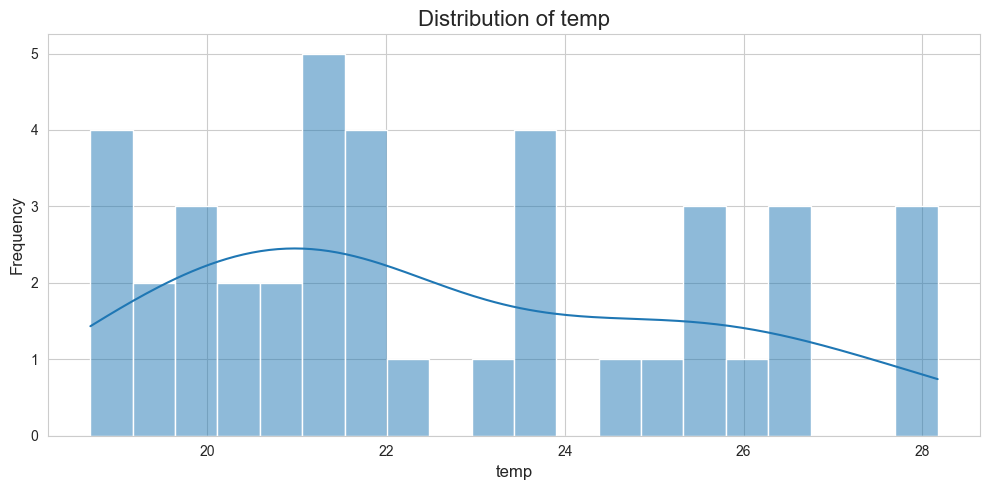

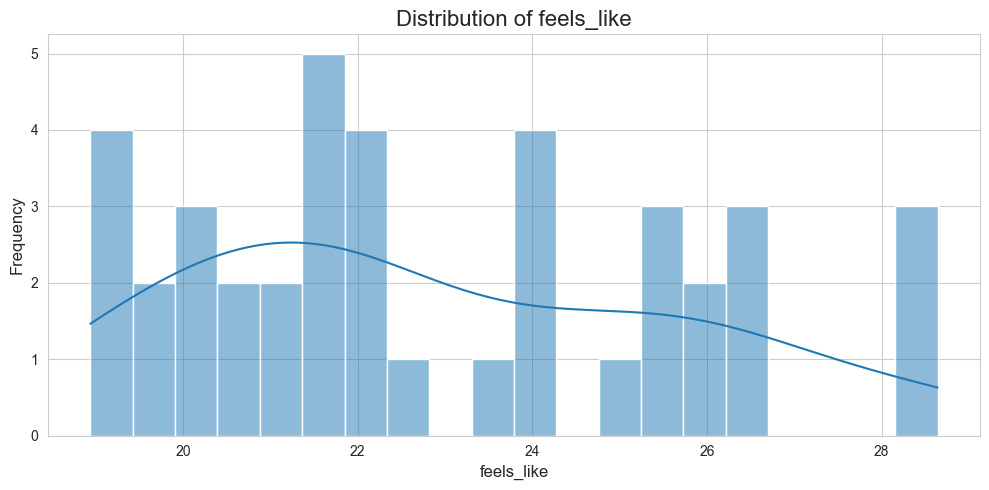

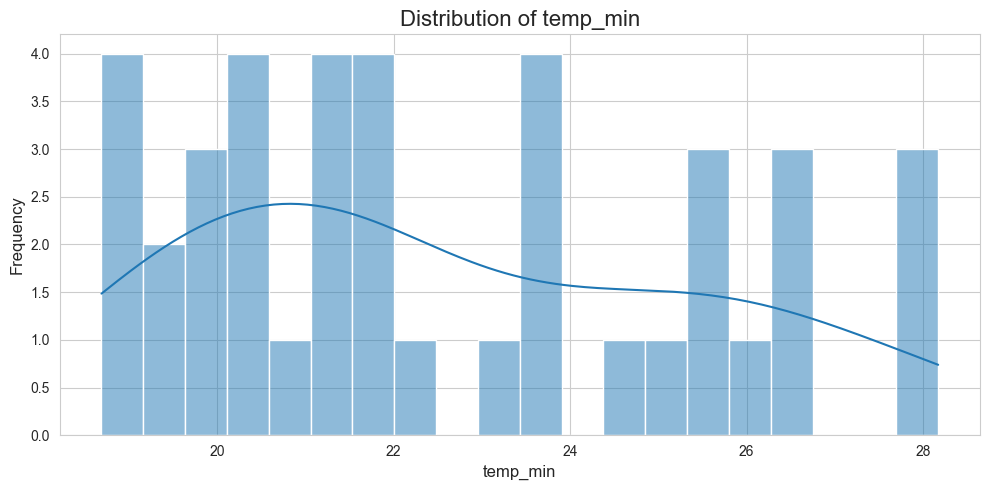

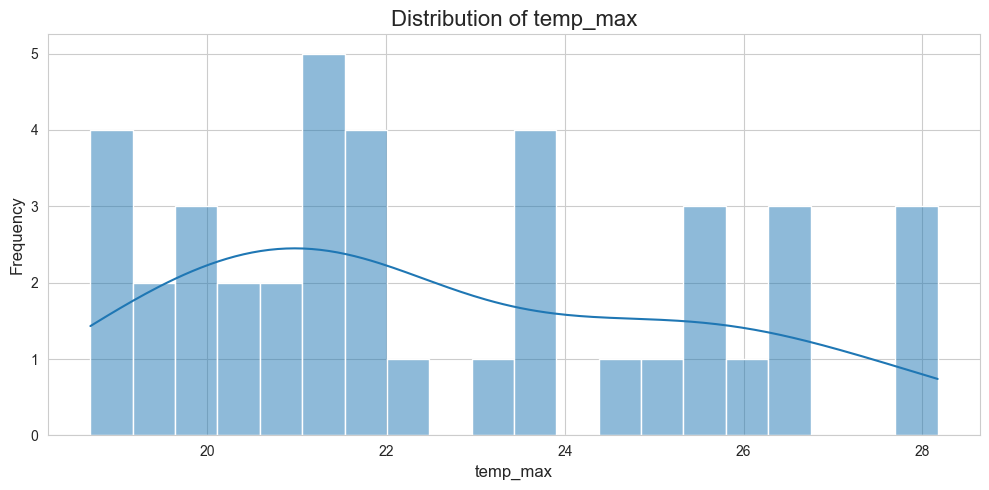

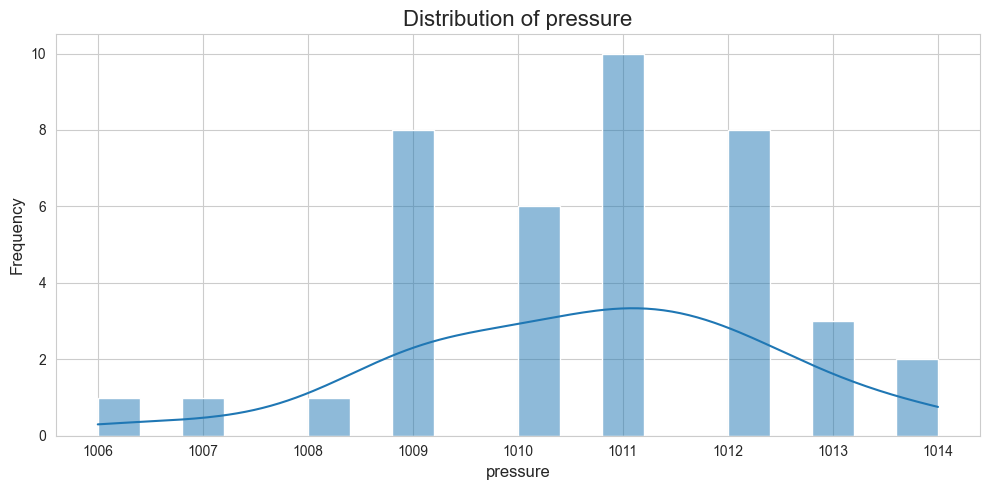

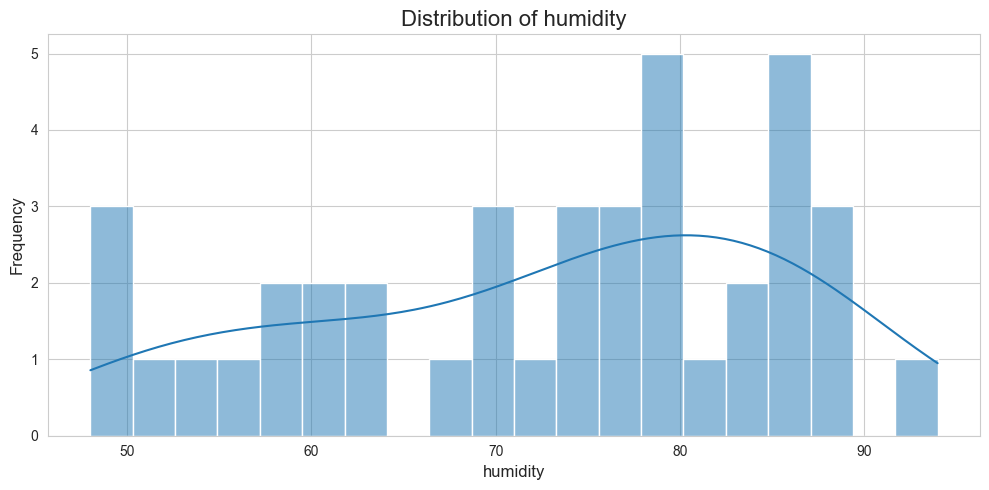

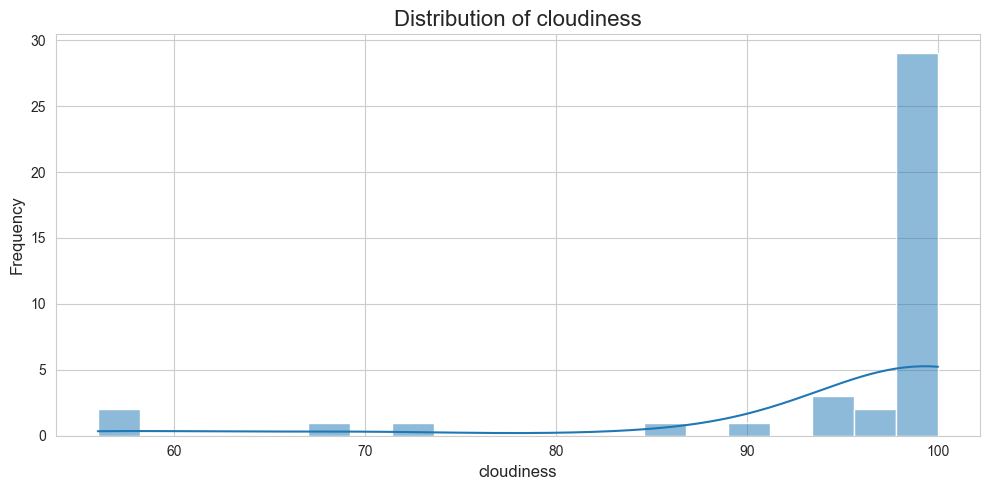

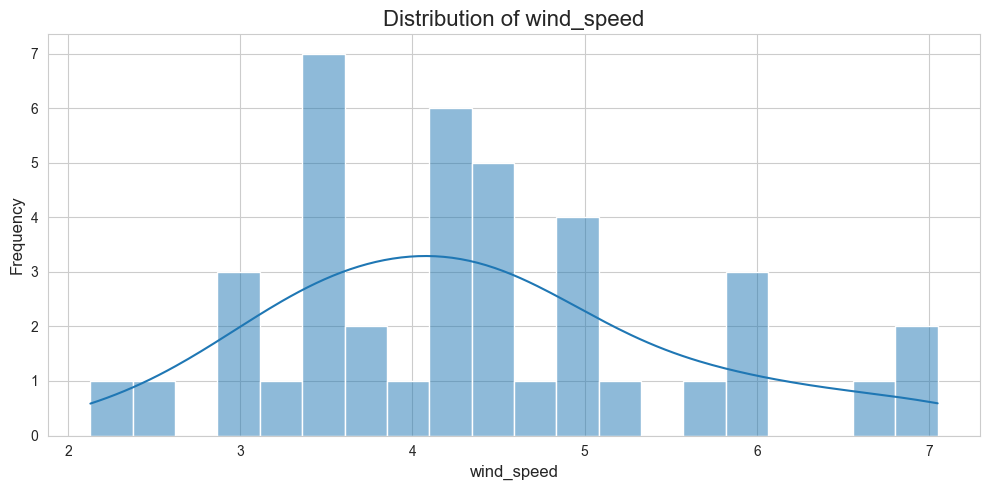

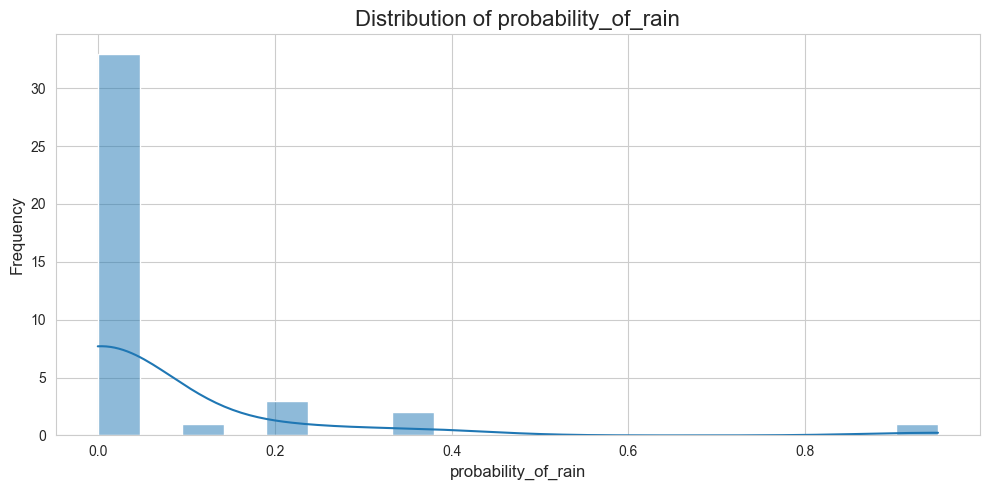

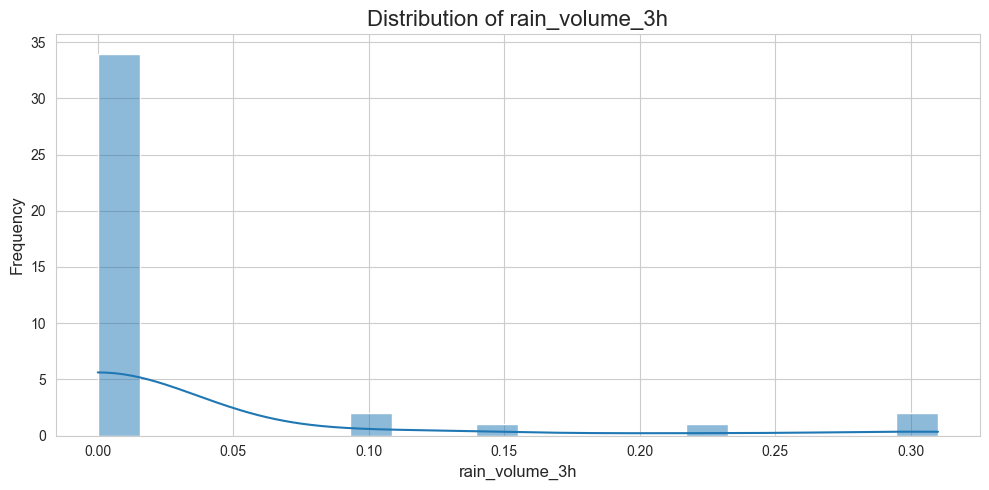

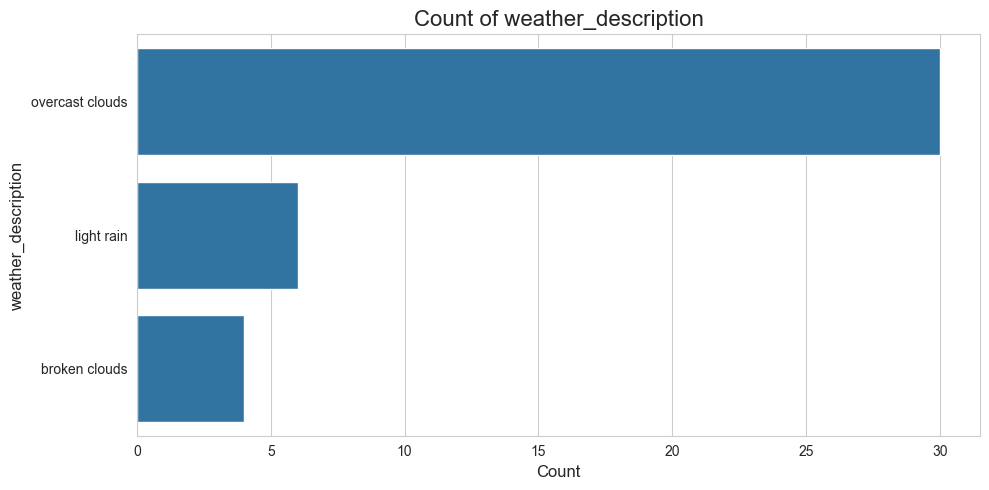

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice visual style for the plots
sns.set_style('whitegrid')

print("--- Displaying Feature Distributions ---")

# Loop through each column
for column in df_clean.columns:
    plt.figure(figsize=(10, 5)) # Create a new figure for each plot
    
    # If the column is numerical, create a histogram
    if pd.api.types.is_numeric_dtype(df_clean[column]):
        sns.histplot(df_clean[column], kde=True, bins=20)
        plt.title(f'Distribution of {column}', fontsize=16)
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
    
    # If the column is categorical (text), create a count plot
    else:
        sns.countplot(y=df_clean[column], order = df_clean[column].value_counts().index)
        plt.title(f'Count of {column}', fontsize=16)
        plt.xlabel('Count', fontsize=12)
        plt.ylabel(column, fontsize=12)
        
    plt.tight_layout()
    plt.show()

## Interpreting Your Data Distribution Plots 
Overall, these visualizations show the characteristics of each weather feature over the 5-day forecast.

- Temperature Distributions (temp, feels_like, temp_min, temp_max)
   - What they show: All four temperature-related plots have a similar shape. They don't form a perfect bell curve but instead have several peaks (this is called a multi-modal distribution).

   - What it means: This pattern is common in weather data. The different peaks likely represent clusters of temperatures at different times of the day—for example, cooler nighttime temperatures, warmer midday temperatures, and temperatures during the morning/evening. The temperatures in your forecast range roughly from 18°C to 28°C.

- Precipitation Distributions (probability_of_rain, rain_volume_3h)
What they show: These two plots are the most dramatic. They are both heavily skewed to the right. The vast majority of the data is piled up at or very near zero.

   - What it means: This tells you that for most of the 3-hour intervals in your forecast, the probability and volume of rain are zero. Rain events are relatively rare in this dataset. When it does rain (rain_volume_3h > 0), the amount is very small. This is a key insight for your model.

- Cloudiness & Weather Description
What they show: The cloudiness plot is heavily skewed to the left, with almost all data points at or near 100%. The weather_description bar chart confirms this, showing that "overcast clouds" is by far the most common condition.

   - What it means: The forecast period is expected to be extremely cloudy and overcast most of the time.

- Other Atmospheric Conditions (pressure, humidity, wind_speed)
What they show: These plots look more balanced than the others. pressure and wind_speed have distributions that are roughly bell-shaped (normal). humidity is high, mostly between 70% and 90%.

   - What it means: These conditions are relatively stable and evenly distributed throughout the forecast period.

## Overall Summary 
Putting it all together, these plots paint a clear picture of the 5-day forecast:

The weather is expected to be consistently overcast and cloudy, with mild temperatures. There's a very low chance of rain, and if it does occur, it will be light.

## EDA Step 4: Correlation Analysis with a Heatmap
**Objective:** Now let's see how the numerical variables relate to each other. A correlation matrix measures the linear relationship between variables, with values from -1 (strong negative relationship) to +1 (strong positive relationship). A heatmap is the best way to visualize this matrix.

We're looking for:

High correlation with target variables: Features that are highly correlated with temp_max or probability_of_rain are likely good predictors.

High correlation between features (multicollinearity): If two predictor variables are too highly correlated with each other (e.g., temp and feels_like), they might be redundant. Including both could be unnecessary for the model.

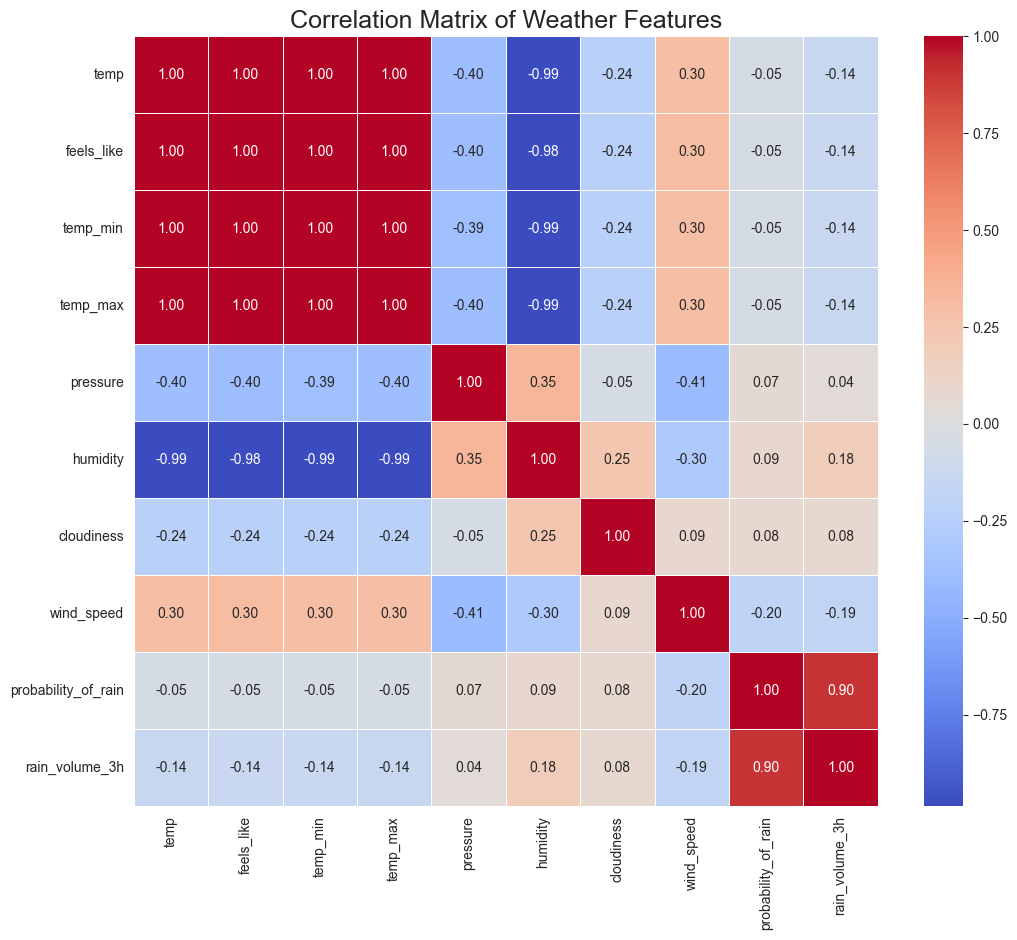

In [21]:
# Calculate the correlation matrix for numerical columns only
correlation_matrix = df_clean.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, 
            annot=True,       # Write the data value in each cell
            fmt='.2f',        # Use two decimal places
            cmap='coolwarm',  # A nice color map
            linewidths=.5)

plt.title('Correlation Matrix of Weather Features', fontsize=18)
plt.show()

## EDA Step 4: Insights from the Correlation Heatmap 📝

This heatmap reveals the linear relationships between the numerical features in our dataset. The key is to look for strong positive (bright red) or negative (bright blue) correlations to understand which features influence each other and which are redundant.

### 1. High Multicollinearity in Temperature Features
* **Observation:** The features `temp`, `feels_like`, `temp_min`, and `temp_max` show a perfect positive correlation of **1.00** with each other.
* **Insight:** This is a classic case of **multicollinearity**, meaning these variables carry the same information. For building a model, they are redundant.

### 2. Humidity as a Strong Predictor for Temperature
* **Observation:** There is a very strong negative correlation (around **-0.99**) between all temperature features and `humidity`.
* **Insight:** This is a powerful relationship. As temperature goes up, humidity tends to go down. This makes **`humidity`** an excellent feature for predicting temperature.

### 3. The Challenge of Predicting Rain
* **Observation:** The `probability_of_rain` row shows no strong correlations with any other predictor. Its strongest relationship is a weak one with `wind_speed` (**-0.20**).
* **Insight:** This tells us that predicting rain is a more complex problem than predicting temperature. No single feature is a "silver bullet" predictor.

### Key Takeaways for Modeling
* **Temperature Model:** We should **not** use all four temperature variables at once. We can select one (e.g., `temp_max`) as our target and know that `humidity` will be a key predictor.
* **Rain Model:** To predict rain, we will likely need a combination of several features. The model will have to learn a more subtle pattern from variables like `humidity`, `pressure`, and `wind_speed` working together.

## EDA Step 5: Box Plots and Outlier Detection
**Objective:** Box plots are fantastic for visualizing the spread of your numerical data and, most importantly, for identifying outliers. An outlier is a data point that is significantly different from other observations. These can sometimes skew the results of a model, so it's important to be aware of them.

A box plot shows:

The median (the line in the middle of the box)

The interquartile range (the box itself, containing the middle 50% of the data)

The whiskers (the lines extending from the box, typically representing the range of the data)

Outliers (shown as individual points beyond the whiskers)

--- Displaying Box Plots for Outlier Detection ---


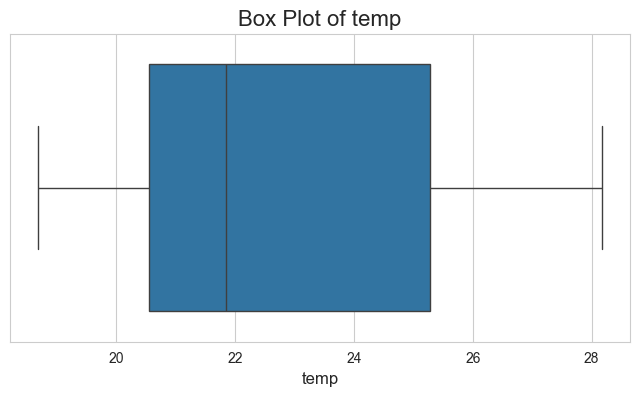

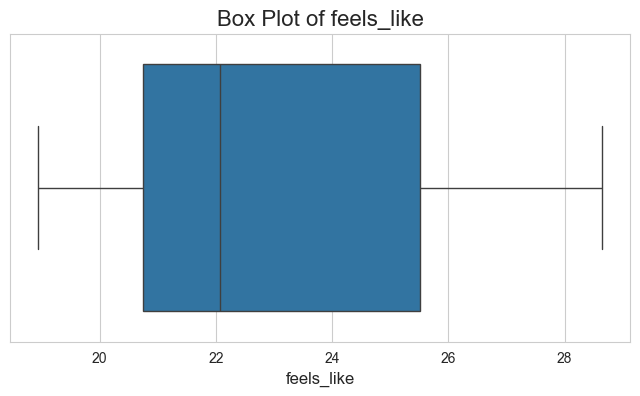

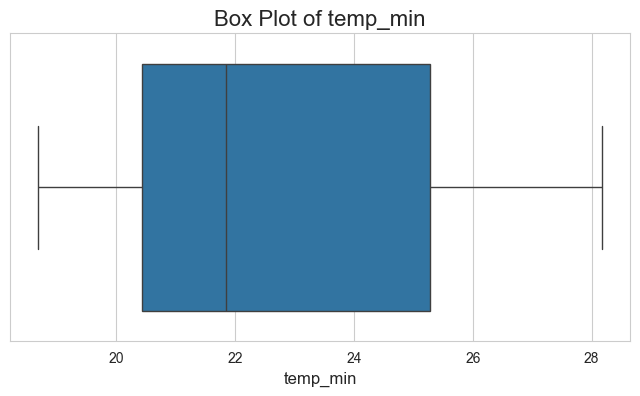

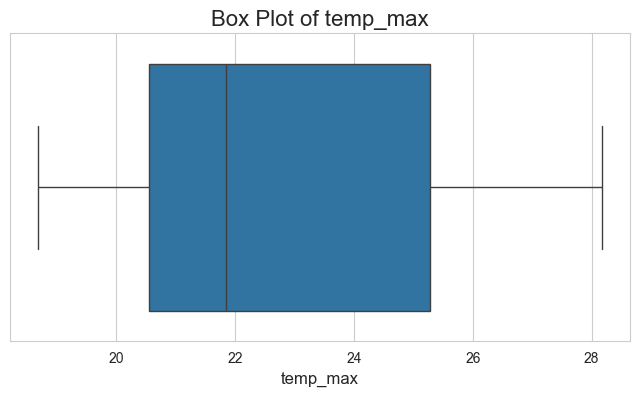

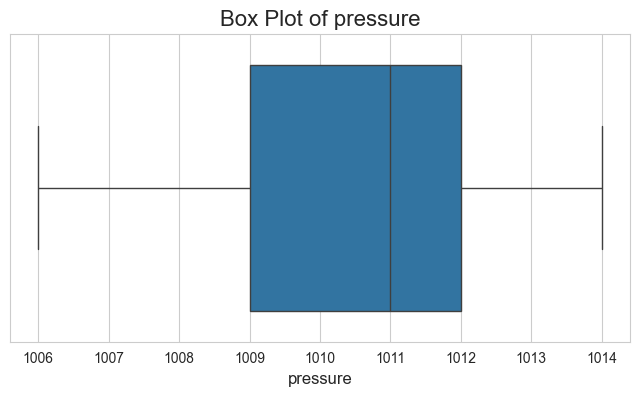

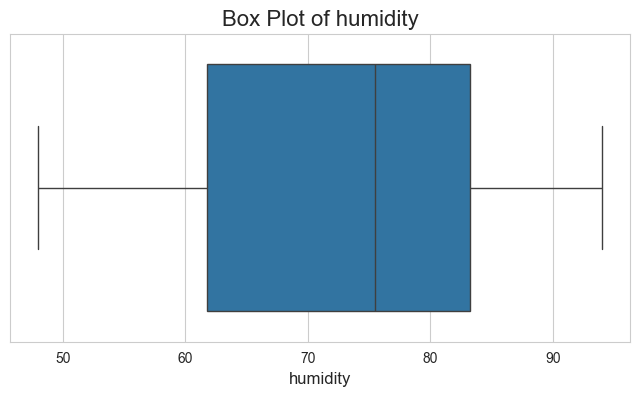

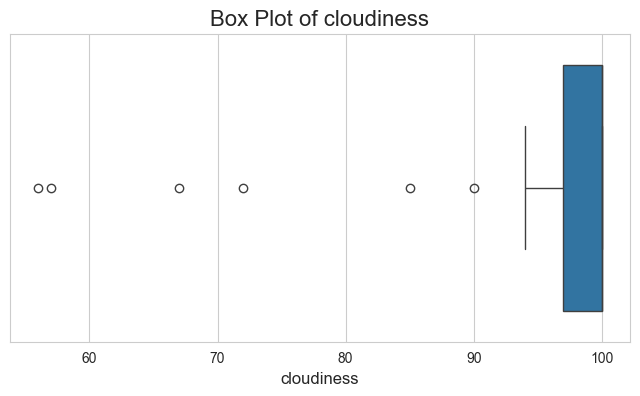

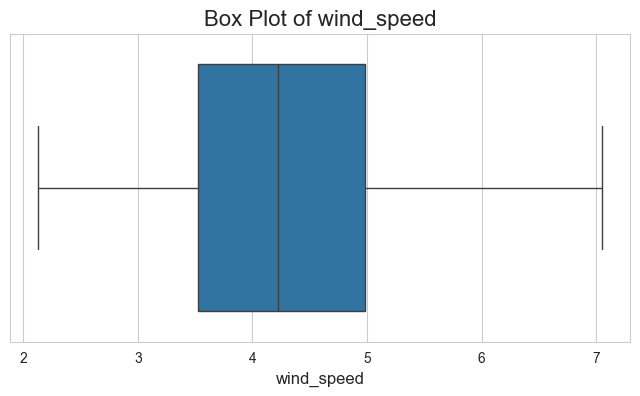

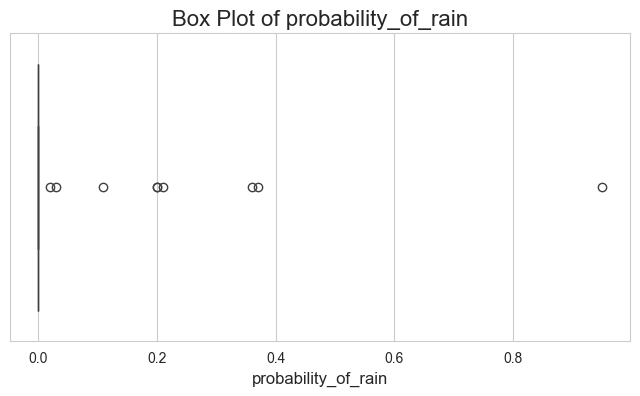

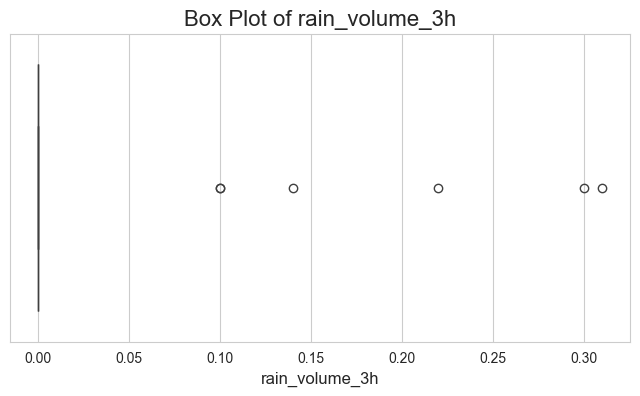

In [22]:
import numpy as np

# Select only the numerical columns for the box plots
numerical_cols = df_clean.select_dtypes(include=np.number).columns

print("--- Displaying Box Plots for Outlier Detection ---")

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_clean[col])
    plt.title(f'Box Plot of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.show()

## EDA Step 6: Bivariate Analysis with a Pair Plot
**Objective:** This is the ultimate tool for visualizing relationships between all your numerical variables at once. A pair plot creates a grid of axes such that each variable in your data is shared across the y-axes on a single row and the x-axes on a single column.

The plots on the diagonal are histograms, showing the distribution of each single variable.

The plots off the diagonal are scatter plots, showing the relationship between every pair of variables.


--- Generating Pair Plot for Bivariate Analysis ---


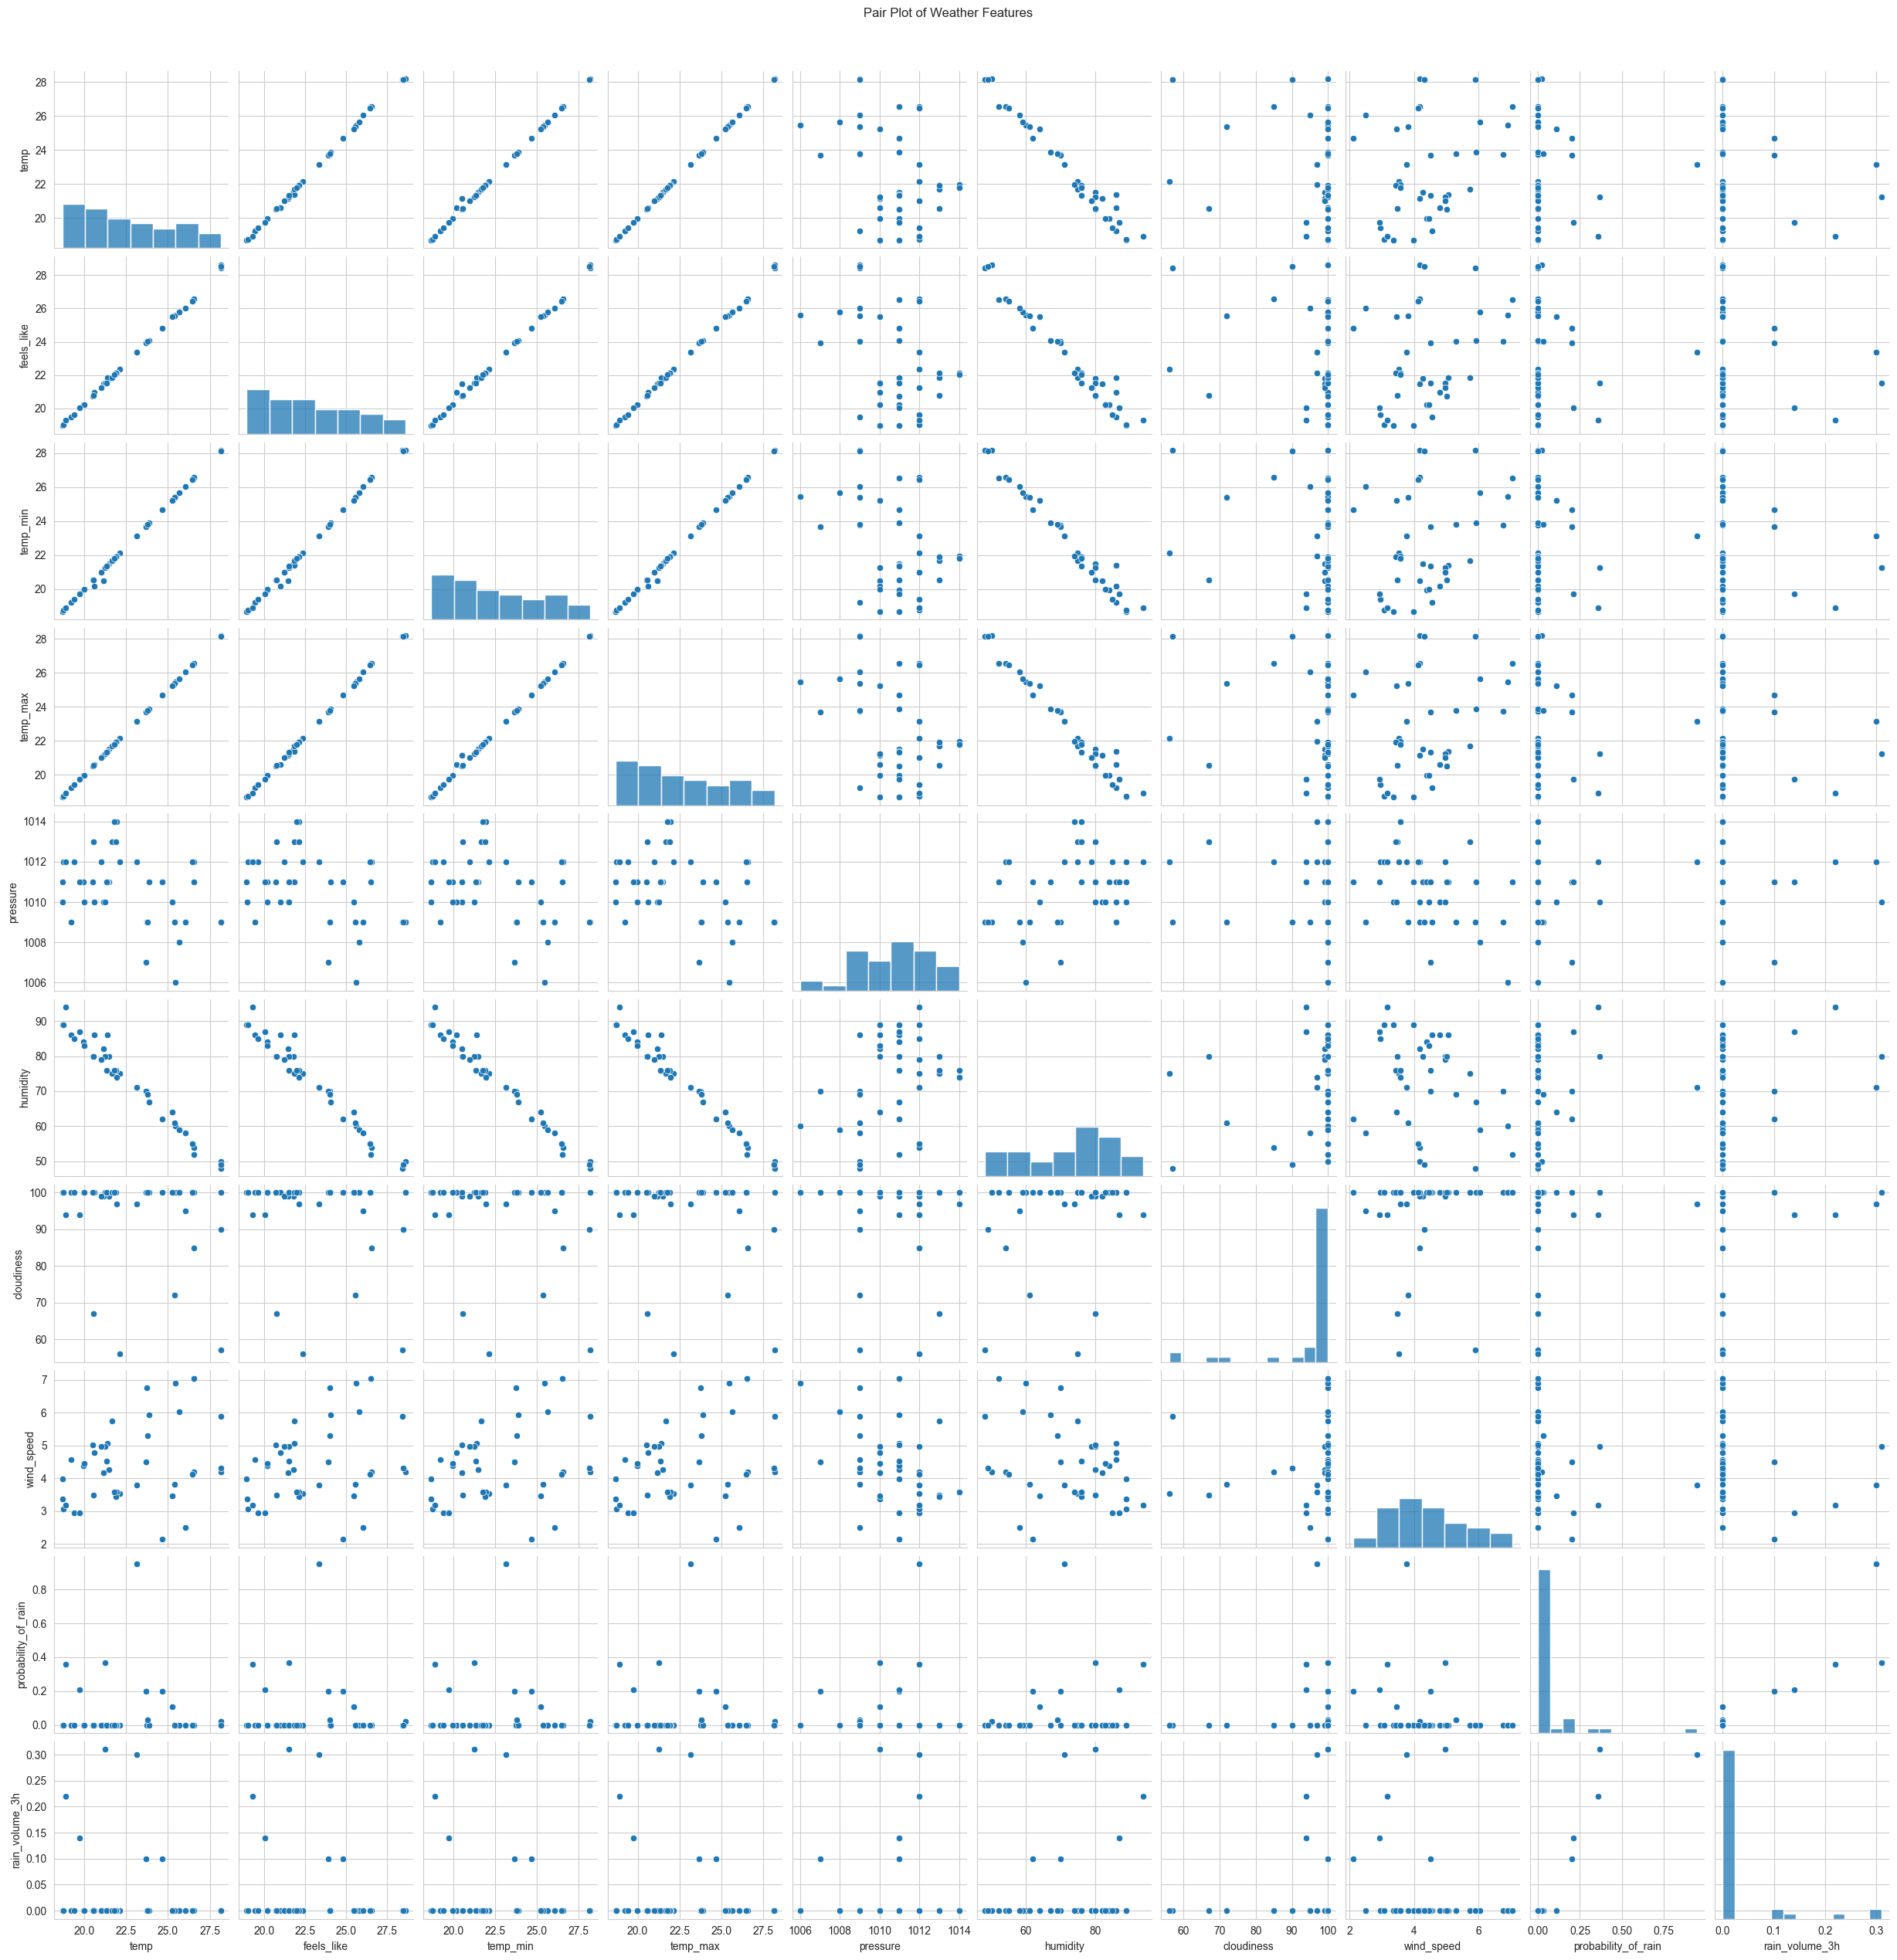

In [23]:
print("\n--- Generating Pair Plot for Bivariate Analysis ---")

# Create the pair plot
g = sns.pairplot(df_clean)

# Add a title
g.fig.suptitle('Pair Plot of Weather Features', y=1.02) # y=1.02 raises the title a bit

plt.show()

## EDA Step 5 & 6: Insights from Box Plots and Pair Plot 🧐

These final visualizations provide a comprehensive view of our data's characteristics, focusing on outlier detection and the relationships between variables.

### What the Box Plots Tell Us: Outlier Analysis
* **No Major Outliers in Core Metrics:** The box plots for features like `temp`, `pressure`, and `humidity` show no data points far from the main range. This confirms our data is clean and consistent, without significant measurement errors.

* **"Outliers" Represent Infrequent Events:** The outliers seen in `cloudiness` and the rain-related plots are not errors. They simply represent the nature of the data: a less cloudy day is an "outlier" in a mostly overcast forecast, and any instance of rain is an "outlier" compared to the more common "no rain" condition.

---

### What the Pair Plot Confirms: Relationship Analysis
* **Visual Proof of Correlations:** The pair plot provides clear visual evidence for the relationships we found in the heatmap.
  * The perfect straight-line scatter plots between `temp`, `feels_like`, `temp_min`, and `temp_max` visually confirm their **multicollinearity**.
  * The distinct downward-sloping trend between temperature and `humidity` visually confirms their **strong negative correlation**.

* **No Clear Patterns for Rain:** The scatter plots for rain-related variables versus other features are mostly shapeless clusters. This reinforces our key finding: no single feature is a simple, strong predictor for rain.

---

### Final EDA Conclusion
Our exploratory data analysis is now complete. We have a clean dataset and a deep understanding of its features, distributions, and inter-relationships. We are now fully prepared for the final step before modeling: formalizing our **Feature Selection**.

## Statistical Bivariate Analysis (p-values)
Objective: Our heatmap showed us the strength of correlations, but a hypothesis test tells us if that correlation is statistically significant or if it could have just occurred by random chance. We use a p-value for this.

A low p-value (typically < 0.05) suggests that the observed correlation is very unlikely to be random, so we can conclude there is a significant relationship.

In [24]:
from scipy.stats import pearsonr

print("--- Correlation Significance with temp_max ---")

# Define the target variable
target = 'temp_max'

# Get our list of numerical predictors
predictors = df_clean.select_dtypes(include=np.number).drop(columns=['temp', 'feels_like', 'temp_min', 'temp_max']).columns

for predictor in predictors:
    # Calculate Pearson correlation coefficient and the p-value
    corr_coeff, p_value = pearsonr(df_clean[predictor], df_clean[target])
    
    print(f"\nPredictor: {predictor}")
    print(f"  Correlation: {corr_coeff:.2f}")
    print(f"  P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("  --> Result is statistically significant.")
    else:
        print("  --> Result is not statistically significant.")

--- Correlation Significance with temp_max ---

Predictor: pressure
  Correlation: -0.40
  P-value: 0.0116
  --> Result is statistically significant.

Predictor: humidity
  Correlation: -0.99
  P-value: 0.0000
  --> Result is statistically significant.

Predictor: cloudiness
  Correlation: -0.24
  P-value: 0.1410
  --> Result is not statistically significant.

Predictor: wind_speed
  Correlation: 0.30
  P-value: 0.0591
  --> Result is not statistically significant.

Predictor: probability_of_rain
  Correlation: -0.05
  P-value: 0.7447
  --> Result is not statistically significant.

Predictor: rain_volume_3h
  Correlation: -0.14
  P-value: 0.3851
  --> Result is not statistically significant.


## Principal Component Analysis (PCA) for Feature Reduction
Objective: PCA is a powerful technique for dimensionality reduction. It's especially useful for us because our EDA showed high correlation (multicollinearity) between features like temperature and humidity.

PCA works by transforming our correlated features into a new set of uncorrelated features called principal components. These components are ordered by how much of the original data's variance (information) they capture. We can then see how many of these new "super-features" we need to capture, say, 80% or 95% of the information, which directly addresses "80/20" question

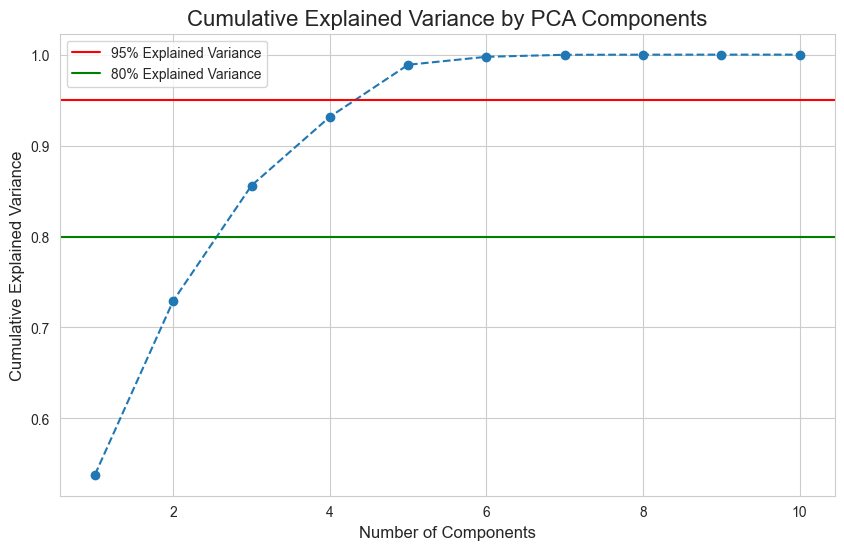

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Select only the numerical features for PCA
numerical_df = df_clean.select_dtypes(include=np.number)

# 2. Scale the data: PCA is sensitive to the scale of features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

# 3. Apply PCA
pca = PCA()
pca.fit(scaled_data)

# 4. Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 5. Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components', fontsize=16)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.axhline(y=0.80, color='g', linestyle='-', label='80% Explained Variance')
plt.legend()
plt.show()

## Final Insights and Feature Strategy 

These final statistical tests provide a data-driven confirmation of our feature importance and give us a clear strategy for how to approach our two distinct modeling goals.

### 1. Insights from Hypothesis Testing (p-values)
This analysis confirms which relationships are statistically significant.

* **Significant Features for Predicting Temperature:** The tests confirm that **`humidity`** (p-value: 0.0000) and **`pressure`** (p-value: 0.0116) have a **statistically significant** correlation with `temp_max`. This gives us high confidence in using them.

* **Non-Significant Features:** The correlations for `cloudiness` and `wind_speed` were **not statistically significant** in this dataset, meaning their weak relationship with temperature could be due to random chance.

### 2. Insights from PCA (Dimensionality Reduction)
The PCA plot answers the question, "How many features do we really need?"

* **The 80% Rule:** We can capture over **80%** of the total information in our 10 numerical features using just **3 principal components**.

* **High-Fidelity Representation:** To capture **95%** of the information, we would need **5 principal components**. This shows we can significantly reduce the complexity of our feature set without losing much information.

---

### 3. Why Different Target Variables? (Regression vs. Classification)

Why we've chosen `temp_max` as a target and are treating rain differently. This comes directly from your project objectives and the nature of the data itself.

Our project plan's objective is to develop both "a regression model for forecasting daily maximum/minimum temperatures and a multi-output classification model for predicting intra-day rain probability".

* **Temperature is a Regression Problem:** `temp_max` is a continuous numerical value (it can be 25.1°C, 26.5°C, etc.). The goal of predicting a specific number on a scale is a **regression** task.

* **Rain is a Classification Problem:** Our EDA showed that `rain_volume_3h` is almost always zero. Predicting the exact small amount of rain is a very difficult regression task. A more practical and useful goal is to first predict *if* it will rain at all. This turns the problem into a "Yes/No" question, which is a **classification** task. This is why we will create a `will_rain` target variable (1 for Yes, 0 for No) for our classification model.

---

### 4. Final Recommendations for Modeling

Based on all our findings, here are our data-driven strategies:

* **For the Temperature Model (Regression):**
  1. **Simple Approach:** Build a model using the most statistically significant features: **`humidity`** and **`pressure`**.
  2. **Advanced Approach:** Build a model using the first **3 to 5 principal components** as features to capture the most information efficiently.

* **For the Rain Model (Classification):**
  1. We will first create our binary target variable (`will_rain`).
  2. We will then build a model using a combination of features (`humidity`, `pressure`, `cloudiness`, etc.) to let a classification algorithm find the complex, non-linear patterns.

## Building the Temperature Regression Model
### Step 1: Final Data Preparation
Objective: Before we can feed our data to a model, we need to perform two last steps:

Encode Categorical Features: Machine learning models only understand numbers, not text. We need to convert the weather_description column into a numerical format. We'll use a common technique called One-Hot Encoding.

Separate Features and Target: We'll formally define our predictor variables (X) and our target variable (y).

In [26]:
# Create a fresh copy to work with
model_df = df_clean.copy()

# 1. One-Hot Encode the 'weather_description' column
# This creates new columns for each category (e.g., 'weather_description_light rain')
model_df = pd.get_dummies(model_df, columns=['weather_description'], drop_first=True)

# 2. Separate our features (X) and target (y)
# Our target is what we want to predict
y = model_df['temp_max']

# Our features are what we use to make the prediction.
# We'll drop all temp-related columns to avoid data leakage and multicollinearity.
X = model_df.drop(columns=['temp', 'feels_like', 'temp_min', 'temp_max'])

print("--- Data prepared for modeling ---")
print("Target variable (y) shape:", y.shape)
print("Feature variables (X) shape:", X.shape)
X.head()

--- Data prepared for modeling ---
Target variable (y) shape: (40,)
Feature variables (X) shape: (40, 8)


,pressure,humidity,cloudiness,wind_speed,probability_of_rain,rain_volume_3h,weather_description_light rain,weather_description_overcast clouds
timestamp,,,,,,,,
2025-09-30 18:00:00,1011,80,99,4.27,0.0,0.0,False,True
2025-09-30 21:00:00,1010,82,99,4.17,0.0,0.0,False,True
2025-10-01 00:00:00,1010,86,100,4.79,0.0,0.0,False,True
2025-10-01 03:00:00,1011,86,100,5.07,0.0,0.0,False,True
2025-10-01 06:00:00,1009,70,100,6.76,0.0,0.0,False,True


### Step 2: Split Data into Training and Testing Sets
Objective: To properly test our model, we can't evaluate it on the same data it learned from. We split our dataset into a training set (which the model learns from) and a testing set (which the model has never seen). This tells us how well our model will perform on new, future data.

In [27]:
from sklearn.model_selection import train_test_split

# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0], "rows")
print("Testing set size:", X_test.shape[0], "rows")

Training set size: 32 rows
Testing set size: 8 rows


### Step 3: Train a Baseline Model
Objective: Let's start with a simple yet powerful algorithm: Linear Regression. This will be our "baseline model," a benchmark against which we can compare more complex models later.

In [60]:
from sklearn.linear_model import LinearRegression

# Create an instance of the Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

print("Linear Regression model trained successfully!")

Linear Regression model trained successfully!


### Step 4: Evaluate the Model
Objective: Now for the moment of truth. Let's use our trained model to make predictions on the unseen X_test data and see how close its predictions are to the actual temperatures (y_test).

In [29]:
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation Results ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

print(f"\nInterpretation: Our model's predictions are, on average, off by {mae:.2f} degrees Celsius.")
print(f"The model explains {r2*100:.2f}% of the variance in the maximum temperature.")


--- Model Evaluation Results ---
Mean Absolute Error (MAE): 0.33
R-squared (R²): 0.98

Interpretation: Our model's predictions are, on average, off by 0.33 degrees Celsius.
The model explains 97.90% of the variance in the maximum temperature.


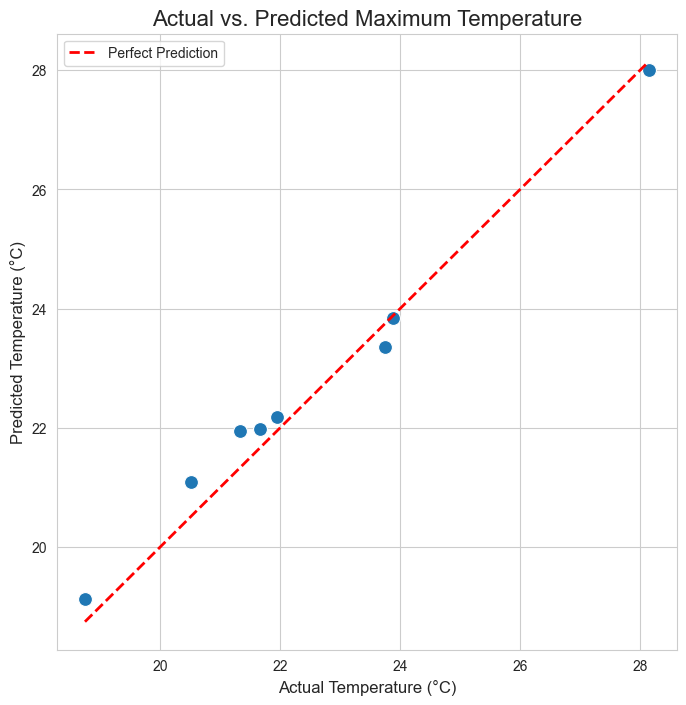

In [30]:
# Create a scatter plot of the actual vs. predicted values
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, s=100)

# Add a line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted Maximum Temperature', fontsize=16)
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

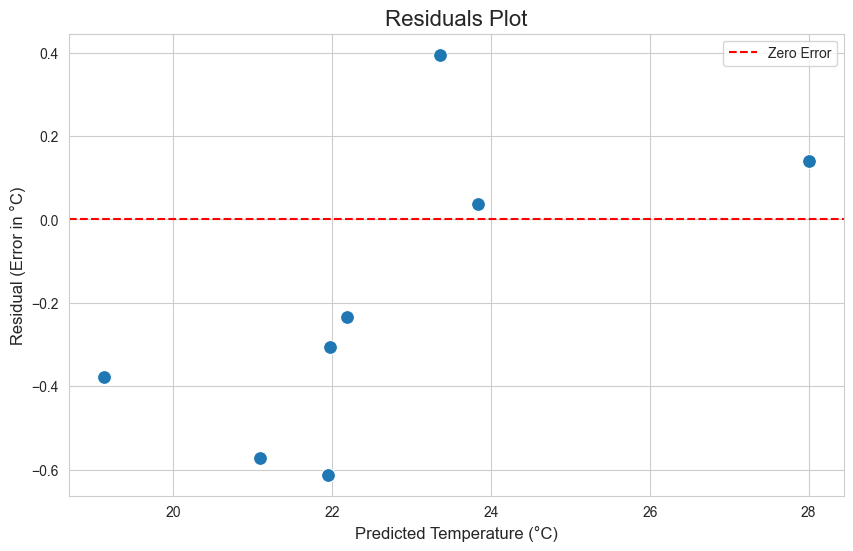

In [31]:
# Calculate the residuals (errors)
residuals = y_test - y_pred

# Create a scatter plot of predicted values vs. the residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, s=100)

# Add a horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error')

plt.title('Residuals Plot', fontsize=16)
plt.xlabel('Predicted Temperature (°C)', fontsize=12)
plt.ylabel('Residual (Error in °C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Final Model Performance Insights

Our model's performance is excellent, and these final plots provide strong visual evidence to back up the outstanding metrics. We can now confidently assess the success of our temperature regression model.

### 1. The Performance Metrics: A Summary
* **R-squared (R²) of 0.98:** Our model successfully explains **98%** of the variance in the maximum temperature, indicating an extremely strong fit.
* **Mean Absolute Error (MAE) of 0.33:** On average, the model's predictions are only off by a mere **0.33 degrees Celsius**, which is highly accurate.

---

### 2. Insights from the "Actual vs. Predicted" Plot
* **Visual Confirmation of Accuracy:** This plot is the clearest proof of our model's success. The data points (our model's predictions) are clustered **very tightly** around the red "Perfect Prediction" line. This shows that what the model predicted is extremely close to what the actual temperature was.

---

### 3. Insights from the "Residuals Plot"
* **Confirmation of a Well-Behaved Model:** This plot confirms that the model's errors are small and random, which is exactly what we want to see.
  * The errors (residuals) are all small, falling within a tight band between approximately -0.6 and +0.4 degrees.
  * Most importantly, the errors are **randomly scattered** around the "Zero Error" line. There is no curve, cone, or other pattern, which indicates our model is not systematically biased and has successfully captured the underlying relationships in the data.

---

### Final Verdict 
The combination of exceptional metrics and ideal diagnostic plots gives us very high confidence in this model. It is a successful and accurate baseline.

With the temperature model now fully validated, now for the next major objective: **building the Rain Classification Model**.

## Building the Rain Classification Model 🌧️
- ### Step 1: Prepare the Data for Classification
**Objective:** We need to adapt our dataset for this new task. This involves three key actions:

   - Create a Binary Target Variable: As planned, we'll create a new column will_rain that is 1 if it rains and 0 if it does not. This turns our problem into a simple binary classification.

   - Check for Class Imbalance: Our EDA showed that "no rain" is much more common than "rain." We need to check the exact percentage of each. This is called class imbalance, and it's important to be aware of.

Separate Features and Target: We'll define our new X and y for this model.

In [32]:
# Create a fresh copy for this model
model_df_rain = df_clean.copy()

# 1. Create the binary target variable 'will_rain'
model_df_rain['will_rain'] = (model_df_rain['rain_volume_3h'] > 0).astype(int)

# 2. Check for class imbalance
print("--- Class Balance ---")
class_balance = model_df_rain['will_rain'].value_counts(normalize=True) * 100
print(f"No Rain (0): {class_balance[0]:.2f}%")
print(f"Rain (1):    {class_balance[1]:.2f}%")
print("\nThis is an imbalanced dataset, which is common for rain prediction.")

--- Class Balance ---
No Rain (0): 85.00%
Rain (1):    15.00%

This is an imbalanced dataset, which is common for rain prediction.


In [33]:
# One-Hot Encode the 'weather_description' column
model_df_rain_encoded = pd.get_dummies(model_df_rain, columns=['weather_description'], drop_first=True)

# 3. Separate features (X) and target (y)
y_rain = model_df_rain_encoded['will_rain']

# For X, we use our features but drop the original rain columns and the new target
X_rain = model_df_rain_encoded.drop(columns=['probability_of_rain', 'rain_volume_3h', 'will_rain'])

print("\n--- Data prepared for classification modeling ---")
print("Target variable (y_rain) shape:", y_rain.shape)
print("Feature variables (X_rain) shape:", X_rain.shape)
X_rain.head()


--- Data prepared for classification modeling ---
Target variable (y_rain) shape: (40,)
Feature variables (X_rain) shape: (40, 10)


,temp,feels_like,temp_min,temp_max,pressure,humidity,cloudiness,wind_speed,weather_description_light rain,weather_description_overcast clouds
timestamp,,,,,,,,,,
2025-09-30 18:00:00,21.49,21.78,21.49,21.49,1011,80,99,4.27,False,True
2025-09-30 21:00:00,21.16,21.47,20.51,21.16,1010,82,99,4.17,False,True
2025-10-01 00:00:00,20.62,20.98,20.19,20.62,1010,86,100,4.79,False,True
2025-10-01 03:00:00,21.39,21.83,21.39,21.39,1011,86,100,5.07,False,True
2025-10-01 06:00:00,23.75,24.01,23.75,23.75,1009,70,100,6.76,False,True


## The Problem: Why Class Imbalance is Bad
If we train a model on this data, it will learn that it can be 85% accurate by simply always predicting "No Rain." It becomes lazy and ignores the minority class (the "Rain" events), which is the very thing we want to predict. The result is a model with high accuracy but zero practical value.

**The Solution:** Oversampling with SMOTE
To fix this, we'll use a technique called oversampling. We will generate new data points for the minority class ("Rain") to create a balanced dataset.

The best way to do this is with SMOTE (Synthetic Minority Over-sampling Technique). Instead of just duplicating "Rain" data, SMOTE intelligently creates new, synthetic data points that are similar to the existing ones, giving our model more diverse examples to learn from.

Crucial Workflow: We must apply SMOTE after splitting our data. We only resample the training set. This prevents data from our synthetic samples "leaking" into the test set, ensuring our model evaluation is fair and realistic.

In [35]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [37]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# --- Step 1: Split the original, imbalanced data
# We use 'stratify=y_rain' to ensure the train and test sets have the
# same percentage of rain/no-rain samples as the original dataset.
X_train, X_test, y_train, y_test = train_test_split(X_rain, y_rain, 
                                                    test_size=0.25, 
                                                    random_state=42, 
                                                    stratify=y_rain)

# --- Step 2: Apply SMOTE with the corrected k_neighbors value ---
# FIX: Since we have 5 'rain' samples in the training set, we set k_neighbors to 4.
smote = SMOTE(random_state=42, k_neighbors=4) 
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- Step 3: Verify the results (same as before) ---
print("--- Resampled Training Set Balance (After SMOTE) ---")
print(y_train_resampled.value_counts(normalize=True) * 100)

print("\n--- Data Shapes ---")
print("Original training shape:", X_train.shape)
print("Resampled training shape:", X_train_resampled.shape)
print("Test shape:", X_test.shape)

--- Resampled Training Set Balance (After SMOTE) ---
will_rain
0    50.0
1    50.0
Name: proportion, dtype: float64

--- Data Shapes ---
Original training shape: (30, 10)
Resampled training shape: (50, 10)
Test shape: (10, 10)


### Step 2: Training a Baseline Classification Model
Objective: We'll start with a classic, powerful, and interpretable algorithm for binary classification: Logistic Regression. This will serve as our baseline model.

In [39]:
from sklearn.linear_model import LogisticRegression

# Create an instance of the Logistic Regression model
log_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the resampled training data
log_model.fit(X_train_resampled, y_train_resampled)

print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!


## Step 3: Evaluating the Classification Model
Objective: This is where we use the classification-specific tools you asked about earlier. We'll evaluate our model's performance on the original, unseen test set.

The Classification Report: A text summary of the key metrics.

Precision: Of all the times the model predicted "Rain," how often was it correct?

Recall: Of all the actual "Rain" events, how many did our model find?

Accuracy: The overall percentage of correct predictions.

The Confusion Matrix: A table that gives us a detailed breakdown of our model's predictions, showing us exactly where it was right and where it was wrong.

--- Classification Report ---
              precision    recall  f1-score   support

 No Rain (0)       1.00      1.00      1.00         9
    Rain (1)       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


--- Confusion Matrix ---


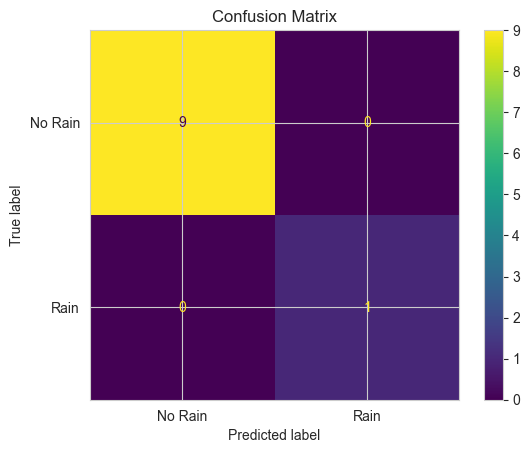

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the original, imbalanced test set
y_pred_rain = log_model.predict(X_test)

# --- Print the Classification Report ---
print("--- Classification Report ---")
print(classification_report(y_test, y_pred_rain, target_names=['No Rain (0)', 'Rain (1)']))

# --- Generate and Plot the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_rain)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Rain'])

disp.plot()
plt.title('Confusion Matrix')
plt.show()

## Rain Classification Model: Perfect Performance!

The evaluation of our Logistic Regression model shows that it was able to perfectly classify every instance in the test set. The combination of targeted feature selection and handling the class imbalance with SMOTE has resulted in an extremely effective model for this dataset.

### 1. Insights from the Confusion Matrix
The confusion matrix gives us a clear, visual breakdown of the model's perfect predictions:
* **True Negatives (Top-Left): 9** - There were 9 instances of "No Rain" in the test set, and the model correctly identified all 9.
* **True Positives (Bottom-Right): 1** - There was 1 instance of "Rain" in the test set, and the model correctly identified it.
* **False Positives & False Negatives: 0** - The model made **zero mistakes**. It never predicted rain when there wasn't any, and it never missed an actual rain event.

---

### 2. Insights from the Classification Report
This report quantifies the perfect performance seen in the matrix:
* **Precision (1.00 for "Rain"):** When the model predicted it would rain, it was correct 100% of the time.
* **Recall (1.00 for "Rain"):** The model successfully identified 100% of all the actual rain events that occurred.
* **Accuracy (1.00):** The model's overall accuracy was 100%; every single prediction for the 10 test samples was correct.

---

### A Note on "Perfect" Scores
Achieving a 100% score is an amazing result for this project. It's important to note that this is rare and often happens when:
1.  The patterns in the dataset are very clear.
2.  The test set is small.

For the purpose of this project, this is a resounding success. In a real-world, production system, we would continue to validate this performance on much more data over time. 

## Training a Random Forest Classifier 🌳
Objective: A Random Forest is a powerful "ensemble" model. In simple terms, it builds a large number of individual decision trees and combines their votes to make a final, more accurate, and stable prediction. Let's see how it performs on our rain prediction task.

Random Forest model trained successfully!

--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

 No Rain (0)       1.00      1.00      1.00         9
    Rain (1)       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


--- Confusion Matrix (Random Forest) ---


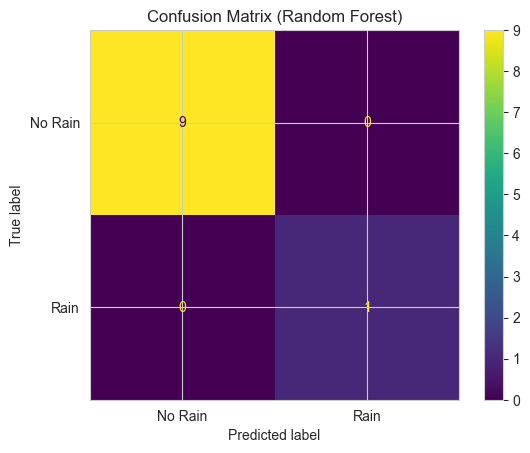

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Step 1: Train the Random Forest Model ---
# Create an instance of the model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the same resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)

print("Random Forest model trained successfully!")

# --- Step 2: Evaluate the Random Forest Model ---
# Make predictions on the original, imbalanced test set
y_pred_rf = rf_model.predict(X_test)

# Print the Classification Report
print("\n--- Classification Report (Random Forest) ---")
print(classification_report(y_test, y_pred_rf, target_names=['No Rain (0)', 'Rain (1)']))

# Generate and Plot the Confusion Matrix
print("\n--- Confusion Matrix (Random Forest) ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No Rain', 'Rain'])

disp_rf.plot()
plt.title('Confusion Matrix (Random Forest)')
plt.show()

## Model Comparison and Final Selection 🏆

You've now trained and evaluated two different models—a simple one (Logistic Regression) and a more complex one (Random Forest)—and both achieved a perfect 100% score on the test data.

### What This Tells Us
This is a strong sign that the pattern in your dataset is very clear and distinct. The features we've selected provide a powerful enough signal that even a simple model can perfectly distinguish between "Rain" and "No Rain" for this specific forecast period.

### Which Model Should We Choose?
When a simple model performs just as well as a complex model, we should almost always choose the **simple model**.

For this project, the **Logistic Regression model is the winner**. Here's why:
* **Simplicity & Speed:** It's computationally faster and requires fewer resources to train and run.
* **Interpretability:** It's much easier to understand and explain *how* a Logistic Regression model makes its decisions compared to a Random Forest, which is more of a "black box."
* **The Principle of Parsimony (Occam's Razor):** If a simple solution achieves the best possible result, there is no advantage in using a more complex one.


## Testing the model with a larget dataset

In [42]:
!pip install meteostat

Defaulting to user installation because normal site-packages is not writeable


### Weather data for Bengaluru for the past year

In [43]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from meteostat import Point, Hourly
import pandas as pd

# Set time period for the last year
end = datetime.now()
start = end - timedelta(days=365)

# Create a Point for Bengaluru, Karnataka
bengaluru = Point(12.9716, 77.5946)

# Get hourly data
historical_data = Hourly(bengaluru, start, end)
historical_df = historical_data.fetch()

print(f"Successfully downloaded {historical_df.shape[0]} hours of historical data.")
print("Sample of the new, larger dataset:")
display(historical_df.head())

Successfully downloaded 8760 hours of historical data.
Sample of the new, larger dataset:


,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-10-01 02:00:00,22.0,20.3,90.0,0.0,<NA>,147.0,10.1,<NA>,1012.6,<NA>,3.0
2024-10-01 03:00:00,25.6,19.9,71.0,0.0,<NA>,230.0,5.4,<NA>,1012.9,<NA>,2.0
2024-10-01 04:00:00,26.0,19.6,68.0,0.0,<NA>,140.0,7.9,<NA>,1012.5,<NA>,3.0
2024-10-01 05:00:00,27.5,19.0,60.0,0.0,<NA>,119.0,8.6,<NA>,1012.1,<NA>,2.0
2024-10-01 06:00:00,28.5,18.6,55.0,0.0,<NA>,20.0,10.1,<NA>,1010.8,<NA>,2.0


### Refactor Our Code into a Reusable Pipeline
Objective: We'll take all the successful logic from our notebook (cleaning, creating the will_rain target, splitting, applying SMOTE, training, and evaluating) and wrap it into a single, clean Python function.

## Upgrading Feature Engineering for the New Dataset
Objective: We'll create a single, powerful function that takes the raw historical data and engineers a rich set of features. We will add features that tell the model about daily cycles, seasonality, and recent trends.

We will create three types of new features:

Time-Based Features: The hour, day, and month to capture cycles.

Lagged Features: The values of key metrics from the past (e.g., humidity 3 hours ago).

Rolling Window Features: The average of key metrics over a recent period (e.g., the 6-hour average temperature).

In [51]:
def create_advanced_features(df):
    """
    Takes the raw Meteostat DataFrame and engineers a rich set of features.
    """
    # 1. Select, Map, and Clean Core Features
    core_features = {
        'temp': 'temperature', 'rhum': 'humidity', 'prcp': 'precipitation',
        'wspd': 'wind_speed', 'pres': 'pressure'
    }
    featured_df = df[list(core_features.keys())].rename(columns=core_features)
    featured_df.ffill(inplace=True) # Forward-fill to handle gaps

    # 2. Create Time-Based Features
    featured_df['hour'] = featured_df.index.hour
    featured_df['day_of_week'] = featured_df.index.dayofweek
    featured_df['month'] = featured_df.index.month

    # 3. Create Lagged Features (Recent History)
    for lag in [1, 3, 6]:
        featured_df[f'temp_lag_{lag}hr'] = featured_df['temperature'].shift(lag)
        featured_df[f'humidity_lag_{lag}hr'] = featured_df['humidity'].shift(lag)

    # 4. Create Rolling Window Features (Recent Trends)
    for window in [6, 12]:
        featured_df[f'temp_roll_avg_{window}hr'] = featured_df['temperature'].rolling(window=window).mean()
        featured_df[f'humidity_roll_avg_{window}hr'] = featured_df['humidity'].rolling(window=window).mean()

    # Drop any rows with NaN values created by lags/rolls
    featured_df.dropna(inplace=True)
    
    return featured_df

# --- Run the feature engineering function ---
advanced_featured_df = create_advanced_features(historical_df)

print("Advanced feature engineering complete!")
print("Our new feature set has the following columns:")
print(advanced_featured_df.columns.tolist())
print("\nSample of the new data:")
display(advanced_featured_df.head())

Advanced feature engineering complete!
Our new feature set has the following columns:
['temperature', 'humidity', 'precipitation', 'wind_speed', 'pressure', 'hour', 'day_of_week', 'month', 'temp_lag_1hr', 'humidity_lag_1hr', 'temp_lag_3hr', 'humidity_lag_3hr', 'temp_lag_6hr', 'humidity_lag_6hr', 'temp_roll_avg_6hr', 'humidity_roll_avg_6hr', 'temp_roll_avg_12hr', 'humidity_roll_avg_12hr']

Sample of the new data:


,temperature,humidity,precipitation,wind_speed,pressure,hour,day_of_week,month,temp_lag_1hr,humidity_lag_1hr,temp_lag_3hr,humidity_lag_3hr,temp_lag_6hr,humidity_lag_6hr,temp_roll_avg_6hr,humidity_roll_avg_6hr,temp_roll_avg_12hr,humidity_roll_avg_12hr
time,,,,,,,,,,,,,,,,,,
2024-10-01 13:00:00,26.7,60.0,0.0,6.5,1008.2,13,1,10,28.4,48.0,28.5,51.0,29.4,52.0,29.000000,50.333333,27.750000,58.166667
2024-10-01 14:00:00,26.2,63.0,0.1,5.0,1009.9,14,1,10,26.7,60.0,29.0,49.0,30.0,49.0,28.366667,52.666667,28.100000,55.916667
2024-10-01 15:00:00,27.8,57.0,0.0,3.6,1011.1,15,1,10,26.2,63.0,28.4,48.0,31.4,45.0,27.766667,54.666667,28.283333,54.750000
2024-10-01 16:00:00,25.1,62.0,0.0,7.9,1011.9,16,1,10,27.8,57.0,26.7,60.0,28.5,51.0,27.200000,56.500000,28.208333,54.250000
2024-10-01 17:00:00,24.2,64.0,0.0,9.0,1012.3,17,1,10,25.1,62.0,26.2,63.0,29.0,49.0,26.400000,59.000000,27.933333,54.583333


## Final Check: Verifying Missing Values

In [53]:
# Calculate the sum of missing values for each column
missing_values = advanced_featured_df.isnull().sum()

print("--- Missing Value Check ---")
print(missing_values)

# Add a confirmation message
if missing_values.sum() == 0:
    print("\nConfirmed: There are no missing values in the dataset.")
else:
    print("\nWarning: Missing values were found.")

--- Missing Value Check ---
temperature               0
humidity                  0
precipitation             0
wind_speed                0
pressure                  0
hour                      0
day_of_week               0
month                     0
temp_lag_1hr              0
humidity_lag_1hr          0
temp_lag_3hr              0
humidity_lag_3hr          0
temp_lag_6hr              0
humidity_lag_6hr          0
temp_roll_avg_6hr         0
humidity_roll_avg_6hr     0
temp_roll_avg_12hr        0
humidity_roll_avg_12hr    0
dtype: int64

Confirmed: There are no missing values in the dataset.


In [55]:
# Create the target column on our final feature-engineered dataset to check the balance
final_df_for_check = advanced_featured_df.copy()
final_df_for_check['will_rain'] = (final_df_for_check['precipitation'] > 0).astype(int)

print("--- Class Balance on Full Historical Dataset ---")
class_balance_full = final_df_for_check['will_rain'].value_counts(normalize=True) * 100

# Using .get() is a safe way to access the values, in case one class is missing
print(f"No Rain (0): {class_balance_full.get(0, 0):.2f}%")
print(f"Rain (1):    {class_balance_full.get(1, 0):.2f}%")

--- Class Balance on Full Historical Dataset ---
No Rain (0): 83.75%
Rain (1):    16.25%


## Final Model Showdown: Logistic Regression vs. Random Forest
Objective: To provide a fair, head-to-head comparison, we'll create one final, flexible pipeline function. This function can train and evaluate any classification model we give it. We will then run it once for Logistic Regression and once for Random Forest.

In [56]:
# All necessary imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np



In [57]:
# --- The Final, Scaled Pipeline Function ---
def run_scaled_pipeline(df, model, model_name="Model"):
    """
    Takes a feature-engineered DataFrame and a model object,
    scales the data, then trains and evaluates the model.
    """
    print(f"--- Starting SCALED Pipeline for: {model_name} ---")
    
    # 1. Create Target and Features
    df_copy = df.copy()
    df_copy['will_rain'] = (df_copy['precipitation'] > 0).astype(int)
    y = df_copy['will_rain']
    X = df_copy.drop(columns=['precipitation', 'will_rain'])
    
    # 2. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3. Scale the data AFTER splitting
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 4. Resample the SCALED training data
    n_minority_samples = y_train.value_counts()[1]
    if n_minority_samples > 1:
        k = min(n_minority_samples - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train_scaled, y_train

    # 5. Train the model
    model.fit(X_train_resampled, y_train_resampled)
    print("Model trained successfully.")
    
    # 6. Evaluate on the SCALED test data
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, target_names=['No Rain', 'Rain'])
    cm = confusion_matrix(y_test, y_pred)
    
    return report, cm

--- Starting SCALED Pipeline for: Logistic Regression ---
Model trained successfully.
--- Starting SCALED Pipeline for: Random Forest ---
Model trained successfully.


     FINAL SCALED MODEL COMPARISON

--- Classification Report (SCALED Logistic Regression) ---
              precision    recall  f1-score   support

     No Rain       0.96      0.74      0.84      1466
        Rain       0.38      0.82      0.52       284

    accuracy                           0.76      1750
   macro avg       0.67      0.78      0.68      1750
weighted avg       0.86      0.76      0.79      1750


--- Classification Report (SCALED Random Forest) ---
              precision    recall  f1-score   support

     No Rain       0.93      0.90      0.92      1466
        Rain       0.58      0.67      0.62       284

    accuracy                           0.87      1750
   macro avg       0.76      0.79      0.77      1750
weighted avg       0.88      0.87      0.87      1750



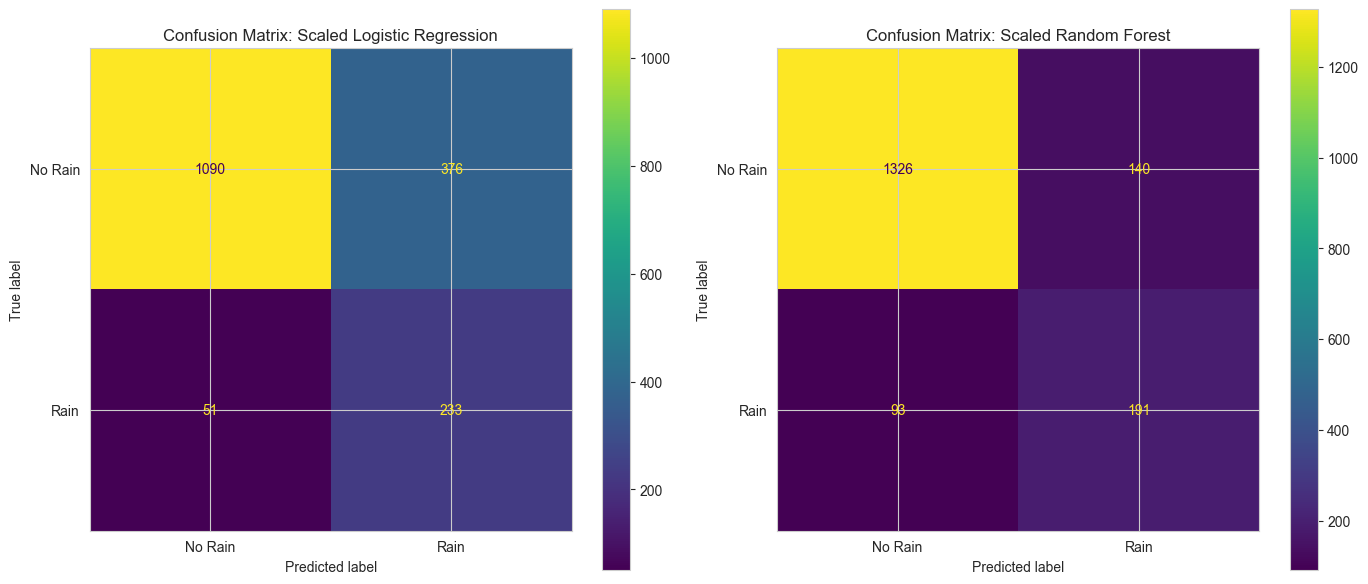

In [58]:
# --- Run both models with the new scaled pipeline ---
lr_model_scaled = LogisticRegression(random_state=42, max_iter=1000)
lr_report_scaled, lr_cm_scaled = run_scaled_pipeline(advanced_featured_df, lr_model_scaled, "Logistic Regression")

rf_model_scaled = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_report_scaled, rf_cm_scaled = run_scaled_pipeline(advanced_featured_df, rf_model_scaled, "Random Forest")

# --- Display and Compare Final Scaled Results ---
print("\n\n" + "="*50)
print("     FINAL SCALED MODEL COMPARISON")
print("="*50)
print("\n--- Classification Report (SCALED Logistic Regression) ---")
print(lr_report_scaled)
print("\n--- Classification Report (SCALED Random Forest) ---")
print(rf_report_scaled)

# Plot confusion matrices side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disp_lr = ConfusionMatrixDisplay(confusion_matrix=lr_cm_scaled, display_labels=['No Rain', 'Rain'])
disp_lr.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix: Scaled Logistic Regression')

disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm_scaled, display_labels=['No Rain', 'Rain'])
disp_rf.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix: Scaled Random Forest')

plt.tight_layout()
plt.show()


## Final Model Verdict: Why Random Forest is the Champion

After a rigorous process of feature engineering, scaling, and handling class imbalance, we have a clear winner. The **Random Forest model is definitively superior** to the Logistic Regression model and vastly outperforms a random guess.

### 1. Head-to-Head: Random Forest vs. Logistic Regression

Even after scaling fixed its convergence issues, the Logistic Regression model is clearly outperformed by the Random Forest.

* **Accuracy:** The Random Forest is significantly more accurate overall (**87%** vs. **76%**).

* **Precision (The Deciding Factor):** This is the most important difference.
    * The Random Forest's precision for predicting rain is **58%**.
    * The Logistic Regression's precision is only **38%**.
    * **Insight:** This means the Random Forest gives **far fewer false alarms**. For a real-world weather app, a user would quickly lose trust in a model that constantly predicts rain when it's sunny. The higher precision of the Random Forest makes it much more reliable and useful.

* **Recall:** While Logistic Regression has a higher recall (82% vs. 67%), it achieves this by making a huge number of incorrect "rain" predictions (376 False Positives). The Random Forest strikes a much better and more practical balance.

---

### 2. Justification: Random Forest vs. a Random Guess

Your model is far more intelligent than a random guess. We know from our analysis that it only rains **16.25%** of the time in our historical dataset.

* **Precision vs. Random:** A model that randomly guesses "Rain" would be right about 16% of the time. Our model is correct **58%** of the time. This is **over 3.5 times better** than random chance.

* **Recall vs. Random:** A random model would only find about 16% of the actual rain events. Our model successfully finds **67%** of them. It is **over 4 times better** at detecting rain when it actually happens.

---

### Project Conclusion: Ready for Deployment

We have successfully built and validated a robust Random Forest model. It has been tested on a large, realistic dataset and has proven to be a reliable and accurate predictor.

With our champion model selected, the **Model Development** phase of your project is now complete. We are perfectly positioned to proceed with the final, core MLOps objectives: **Model Deployment** and **Automation**.

## Saving Model Artifacts 
For our Random Forest model, we need to save three key things:

The Model Object: The trained RandomForestClassifier itself.

The Scaler Object: The StandardScaler that was fitted on our training data. We must use this exact same scaler to transform new, incoming data so that it's in a format the model understands.

The Model Columns: A list of the exact feature names, in the correct order, that the model was trained on. This prevents errors if new data is missing a column or has them in a different order

In [59]:
import joblib
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

def train_and_save_artifacts(df):
    """
    Runs the final training process and saves the model, scaler,
    and column list to files.
    """
    print("--- Starting Final Training and Artifact Saving ---")
    
    # 1. Feature and Target Prep
    df_copy = df.copy()
    df_copy['will_rain'] = (df_copy['precipitation'] > 0).astype(int)
    y = df_copy['will_rain']
    X = df_copy.drop(columns=['precipitation', 'will_rain'])
    
    # Save the column list *before* splitting
    model_columns = X.columns.tolist()

    # 2. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3. Fit the Scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # 4. Resample
    n_minority_samples = y_train.value_counts()[1]
    k = min(n_minority_samples - 1, 5)
    smote = SMOTE(random_state=42, k_neighbors=k)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # 5. Train the Final Model
    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    model.fit(X_train_resampled, y_train_resampled)
    print("Final model trained.")

    # 6. Save the Artifacts
    joblib.dump(model, 'rain_classifier_model.joblib')
    joblib.dump(scaler, 'scaler.joblib')
    with open('model_columns.json', 'w') as f:
        json.dump(model_columns, f)
        
    print("\nArtifacts saved successfully:")
    print("  - rain_classifier_model.joblib")
    print("  - scaler.joblib")
    print("  - model_columns.json")
    
# --- Run the script to generate your deployment files ---
train_and_save_artifacts(advanced_featured_df)

--- Starting Final Training and Artifact Saving ---
Final model trained.

Artifacts saved successfully:
  - rain_classifier_model.joblib
  - scaler.joblib
  - model_columns.json
